In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size, get_ordered_colors
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path
from csv_reader import read_csv
from csv_writer import write_csv
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import glob

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2.0

warnings.filterwarnings('ignore')


In [4]:
def calc_entropy(l):
    abs_l = np.abs(l)[np.abs(l) > 0]
    per_l = abs_l / np.sum(abs_l)
    return -np.dot(np.log(per_l), per_l)

def normalize(x):
    x_ = np.array(x)
    x_ = (x_ - np.mean(x_))
    return x_ / np.std(x_)

def extract_kernel(w):
    kernel = np.zeros((w.shape[0], w.shape[1] * 2), dtype=float)
    for i in range(0, w.shape[0]):
        a = slice((w.shape[1]-i), w.shape[1], 1)
        kernel[i, a] = w[i, :i]
        b = slice(w.shape[1], 2 * w.shape[1] - i, 1)
        kernel[i, b] = w[i, i:]
    return kernel

def sort_key(s):
    idx_loc = s.find('INDEX_') + 6
    s_trunc = s[idx_loc:]
    idx_und = s_trunc.find('_')
    return int(s_trunc[:idx_und])

In [ ]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_15:06:01.964623'
saved_weights_path = test_data_path = f'./sims_out/{file_name}/weight_matrices.csv'

all_w = read_csv(saved_weights_path, read_header=False)
weight_mat_side_len = np.sqrt(all_w.shape[1]).astype(int)
print(weight_mat_side_len)
all_w = [np.array(all_w.iloc[i]).reshape((weight_mat_side_len, weight_mat_side_len)) for i in range(all_w.shape[0])]

Summed ee, lag 2 0.30400365324811884
Summed ee, lag 1 0.2657932923218968
Summed ee, lag 0 0.5960398643239309
Summed ie, lag 1 0.2934163594610156
[ 0.02043334 -0.15039804  0.46810116  0.23723947]
0.3937997154238243


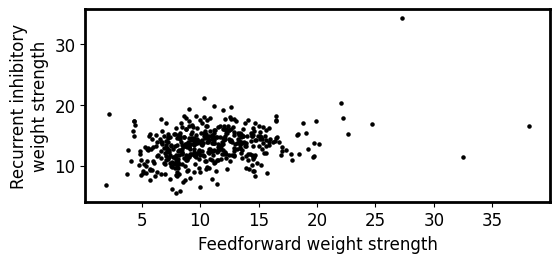

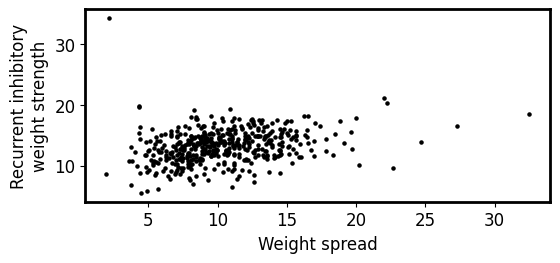

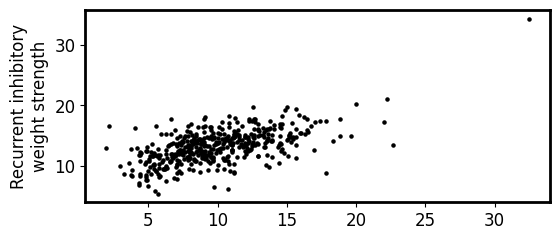

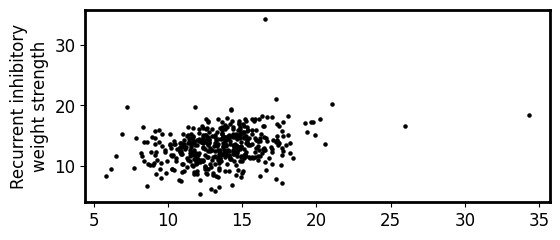

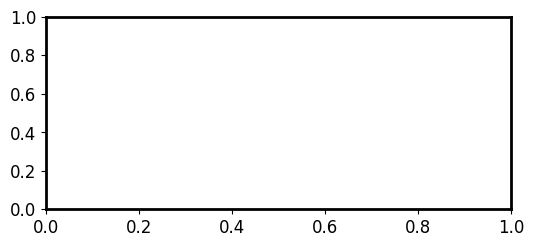

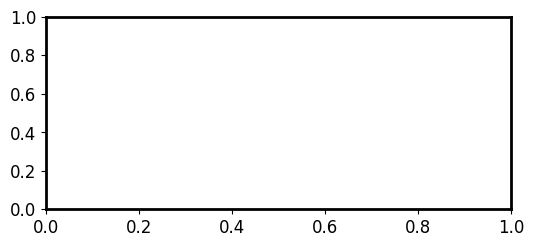

In [256]:
scale = 1
corr_fig, corr_axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_2, corr_axs_2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_3, corr_axs_3 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_inh, corr_axs_inh = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

corr_fig_4, corr_axs_4 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_5, corr_axs_5 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

all_w_ee_summed = []
all_w_ee_summed_lag_1 = []
all_w_ee_summed_lag_2 = []
all_w_ie_summed = []
all_w_ie_summed_lag_1 = []
all_w_ie_summed_lag_2 = []
all_w_count = []
all_w_ee_maxs = []
all_w_ee_spreads = []

for w in all_w:
#     fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    
    w_ee_entropy = np.array([calc_entropy(w[i, :25]) for i in range(25)])
    
    w_ee_summed = w[:25, :25].sum(axis=1)
    w_ee_summed_lag_1 = np.concatenate([w_ee_summed[1:], [np.nan]])
    w_ee_summed_lag_2 = np.concatenate([w_ee_summed[2:], [np.nan, np.nan]])
            
    w_ie_summed = np.zeros(25)
    w_count = np.zeros(25)
    w_ee_max = w[:25, :25].max(axis=1)
    w_ee_spread = np.zeros(25)
    
    
    for i in range(25):
        w_ee_spread[i] = np.sum(np.abs(i - np.arange(25)) * (w[i, :25] / np.sum(w[i, :25])))
        w_count[i] = np.count_nonzero(w[i, np.maximum(i-5, 0):i] > 1e-6, axis=0)
        w_ie_summed[i] = (w[np.maximum(i, 0):np.minimum(25, i+1), 25:]).sum()

        
    w_ie_summed_lag_1 = np.concatenate([w_ie_summed[1:], [np.nan]])
    w_ie_summed_lag_2 = np.concatenate([w_ie_summed[2:], [np.nan, np.nan]])
#     axs.plot(np.arange(25), w_ee_summed, color='red')
#     axs.plot(np.arange(25), np.abs(w_ie_summed), color='blue')
#     axs.plot(np.arange(25), w_count, color='black')
    
    all_w_ee_summed += list(w_ee_summed[5:23])
    all_w_ee_summed_lag_1 += list(np.abs(w_ee_summed_lag_1[5:23]))
    all_w_ee_summed_lag_2 += list(np.abs(w_ee_summed_lag_2[5:23]))
    all_w_ie_summed += list(np.abs(w_ie_summed[5:23]))
    all_w_ie_summed_lag_1 += list(np.abs(w_ie_summed_lag_1[5:23]))
    all_w_ie_summed_lag_2 += list(np.abs(w_ie_summed_lag_2[5:23]))
    all_w_count += list(w_count[5:])
    all_w_ee_maxs += list(w_ee_max[5:] / w_ee_summed[5:])
    all_w_ee_spreads += list(w_ee_spread[5:])

all_w_ee_summed = np.array(all_w_ee_summed)
all_w_ee_summed_lag_1 = np.array(all_w_ee_summed_lag_1)
all_w_ee_summed_lag_2 = np.array(all_w_ee_summed_lag_2)
all_w_ie_summed = np.array(all_w_ie_summed)
all_w_ie_summed_lag_1 = np.array(all_w_ie_summed_lag_1)
all_w_ie_summed_lag_2 = np.array(all_w_ie_summed_lag_2)
corr_axs.scatter(all_w_ee_summed, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs.set_xlabel('Feedforward weight strength')
corr_axs.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed, all_w_ie_summed_lag_2)
print('Summed ee, lag 2', res.rvalue)

# need to control for total synapse strength here

# corr_axs_2.scatter(all_w_count + np.random.normal(size=len(all_w_count), scale=0.1), all_w_ie_summed, color='black', s=5)
# res = linregress(all_w_count, all_w_ie_summed)
# print(res.rvalue)

corr_axs_2.scatter(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs_2.set_xlabel('Weight spread')
corr_axs_2.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ee, lag 1', res.rvalue)

corr_axs_3.scatter(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_3.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
print('Summed ee, lag 0', res.rvalue)

corr_axs_inh.scatter(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_inh.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ie, lag 1', res.rvalue)

# cbar = corr_axs_3.scatter(all_w_ee_summed, all_w_ee_summed_lag_1, c=all_w_ie_summed_lag_1, s=5, cmap='plasma')
# corr_axs_3.set_xlim(0, 25)
# corr_axs_3.set_ylim(0, 25)
# corr_axs_3.set_xlabel('Cov 1')
# corr_axs_3.set_ylabel('Cov 2')
# corr_fig_3.colorbar(cbar)


# corr_axs_4.scatter(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# corr_axs_4.set_xlim(0, 500)
# res = linregress(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
# print(res.rvalue)

# corr_axs_5.scatter(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# # corr_axs_5.set_xlim(0, 500)
# res = linregress(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
# print(res.rvalue)


# corr_axs_3.set_title('Recurrent inhibitory\nweight strength')

# Todo: fit a model with max synapse size AND total synaptic strength, see if this better correlates?
# evidently not

reg = LinearRegression().fit(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2)
print(reg.coef_)
print(reg.score(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2))

In [173]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_14:46:45.499087'
saved_weights_path = test_data_path = f'./sims_out/{file_name}/weight_matrices.csv'

all_w = read_csv(saved_weights_path, read_header=False)
weight_mat_side_len = np.sqrt(all_w.shape[1]).astype(int)
print(weight_mat_side_len)
all_w = [np.array(all_w.iloc[i]).reshape((weight_mat_side_len, weight_mat_side_len)) for i in range(all_w.shape[0])]

33


Summed ee, lag 2 0.014120332503881337
Summed ee, lag 1 -0.06039864705314543
Summed ee, lag 0 0.4943751168596442
Summed ie, lag 1 0.09365092177126609
[-0.01051532 -0.04186676  0.0986287   0.2015043 ]
0.29443103277640037


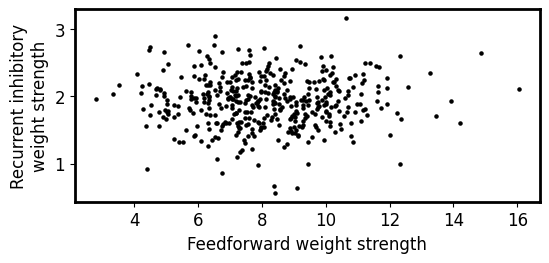

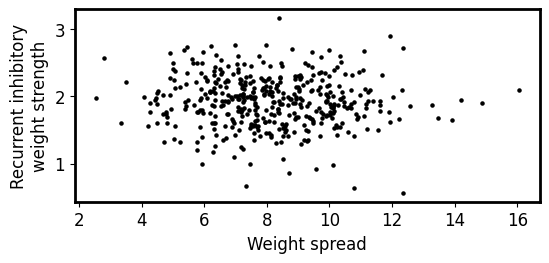

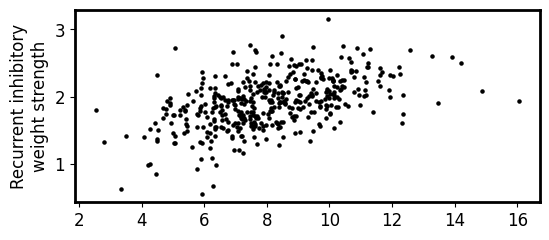

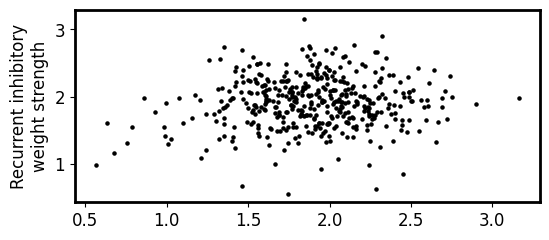

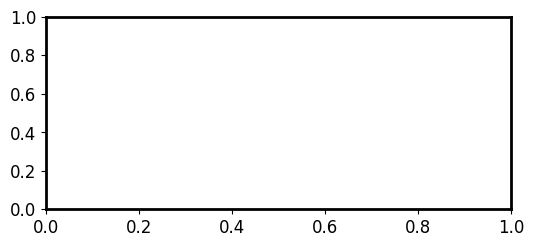

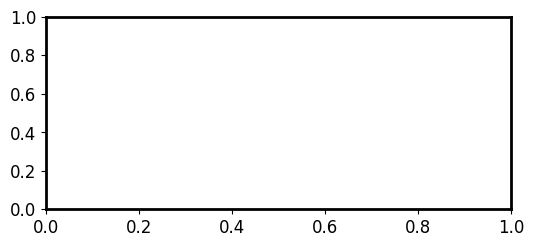

In [174]:
scale = 1
corr_fig, corr_axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_2, corr_axs_2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_3, corr_axs_3 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_inh, corr_axs_inh = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

corr_fig_4, corr_axs_4 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
corr_fig_5, corr_axs_5 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

all_w_ee_summed = []
all_w_ee_summed_lag_1 = []
all_w_ee_summed_lag_2 = []
all_w_ie_summed = []
all_w_ie_summed_lag_1 = []
all_w_ie_summed_lag_2 = []
all_w_count = []
all_w_ee_maxs = []
all_w_ee_spreads = []

for w in all_w:
#     fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    
    w_ee_entropy = np.array([calc_entropy(w[i, :25]) for i in range(25)])
    
    w_ee_summed = w[:25, :25].sum(axis=1)
    w_ee_summed_lag_1 = np.concatenate([w_ee_summed[1:], [np.nan]])
    w_ee_summed_lag_2 = np.concatenate([w_ee_summed[2:], [np.nan, np.nan]])
            
    w_ie_summed = np.zeros(25)
    w_count = np.zeros(25)
    w_ee_max = w[:25, :25].max(axis=1)
    w_ee_spread = np.zeros(25)
    
    
    for i in range(25):
        w_ee_spread[i] = np.sum(np.abs(i - np.arange(25)) * (w[i, :25] / np.sum(w[i, :25])))
        w_count[i] = np.count_nonzero(w[i, np.maximum(i-5, 0):i] > 1e-6, axis=0)
        w_ie_summed[i] = (w[np.maximum(i, 0):np.minimum(25, i+1), 25:]).sum()

        
    w_ie_summed_lag_1 = np.concatenate([w_ie_summed[1:], [np.nan]])
    w_ie_summed_lag_2 = np.concatenate([w_ie_summed[2:], [np.nan, np.nan]])
#     axs.plot(np.arange(25), w_ee_summed, color='red')
#     axs.plot(np.arange(25), np.abs(w_ie_summed), color='blue')
#     axs.plot(np.arange(25), w_count, color='black')
    
    all_w_ee_summed += list(w_ee_summed[5:23])
    all_w_ee_summed_lag_1 += list(np.abs(w_ee_summed_lag_1[5:23]))
    all_w_ee_summed_lag_2 += list(np.abs(w_ee_summed_lag_2[5:23]))
    all_w_ie_summed += list(np.abs(w_ie_summed[5:23]))
    all_w_ie_summed_lag_1 += list(np.abs(w_ie_summed_lag_1[5:23]))
    all_w_ie_summed_lag_2 += list(np.abs(w_ie_summed_lag_2[5:23]))
    all_w_count += list(w_count[5:])
    all_w_ee_maxs += list(w_ee_max[5:] / w_ee_summed[5:])
    all_w_ee_spreads += list(w_ee_spread[5:])

all_w_ee_summed = np.array(all_w_ee_summed)
all_w_ee_summed_lag_1 = np.array(all_w_ee_summed_lag_1)
all_w_ee_summed_lag_2 = np.array(all_w_ee_summed_lag_2)
all_w_ie_summed = np.array(all_w_ie_summed)
all_w_ie_summed_lag_1 = np.array(all_w_ie_summed_lag_1)
all_w_ie_summed_lag_2 = np.array(all_w_ie_summed_lag_2)
corr_axs.scatter(all_w_ee_summed, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs.set_xlabel('Feedforward weight strength')
corr_axs.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed, all_w_ie_summed_lag_2)
print('Summed ee, lag 2', res.rvalue)

# need to control for total synapse strength here

# corr_axs_2.scatter(all_w_count + np.random.normal(size=len(all_w_count), scale=0.1), all_w_ie_summed, color='black', s=5)
# res = linregress(all_w_count, all_w_ie_summed)
# print(res.rvalue)

corr_axs_2.scatter(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
corr_axs_2.set_xlabel('Weight spread')
corr_axs_2.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ee, lag 1', res.rvalue)

corr_axs_3.scatter(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_3.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
print('Summed ee, lag 0', res.rvalue)

corr_axs_inh.scatter(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# corr_axs_3.set_xlabel('Weight spread')
corr_axs_inh.set_ylabel('Recurrent inhibitory\nweight strength')
res = linregress(all_w_ie_summed_lag_1, all_w_ie_summed_lag_2)
print('Summed ie, lag 1', res.rvalue)

# cbar = corr_axs_3.scatter(all_w_ee_summed, all_w_ee_summed_lag_1, c=all_w_ie_summed_lag_1, s=5, cmap='plasma')
# corr_axs_3.set_xlim(0, 25)
# corr_axs_3.set_ylim(0, 25)
# corr_axs_3.set_xlabel('Cov 1')
# corr_axs_3.set_ylabel('Cov 2')
# corr_fig_3.colorbar(cbar)


# corr_axs_4.scatter(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# corr_axs_4.set_xlim(0, 500)
# res = linregress(all_w_ee_summed * all_w_ee_summed_lag_1, all_w_ie_summed_lag_2)
# print(res.rvalue)

# corr_axs_5.scatter(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2, color='black', s=5)
# # corr_axs_4.set_xlabel('Weight spread')
# # corr_axs_4.set_ylabel('Recurrent inhibitory\nweight strength')
# # corr_axs_5.set_xlim(0, 500)
# res = linregress(all_w_ee_summed_lag_1 * all_w_ee_summed_lag_2, all_w_ie_summed_lag_2)
# print(res.rvalue)


# corr_axs_3.set_title('Recurrent inhibitory\nweight strength')

# Todo: fit a model with max synapse size AND total synaptic strength, see if this better correlates?
# evidently not

reg = LinearRegression().fit(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2)
print(reg.coef_)
print(reg.score(np.array([all_w_ee_summed, all_w_ee_summed_lag_1, all_w_ee_summed_lag_2, all_w_ie_summed_lag_1]).T, all_w_ie_summed_lag_2))

In [17]:
def plot_activity(file_names, repeats=30):
    for file_name in file_names:
        all_rs = []

        for i in range(11):
            saved_activity_path = f'./sims_out/{file_name}/all_r_{i}.csv'

            all_r = read_csv(saved_activity_path, read_header=False)
            all_r = np.array(all_r)
            total_steps = all_r.shape[0]

            all_r = all_r.reshape(repeats, int(total_steps/repeats), 25)
            all_rs.append(all_r)

        all_rs = np.stack(all_rs)
        
    layer_colors = get_ordered_colors('gist_rainbow', 25)
        
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

    scale = 1
    fig_timing, axs_timing = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

    for i in range(all_rs.shape[1]):
        fig_activity, axs_activity = plt.subplots(1, 3, figsize=(12 * scale, 12 * scale))

        rs = all_rs[:, i, ...]
        T = 0.11 # Total duration of one network simulation
        dt = 1e-4 # Timestep
        t = np.linspace(0, T, int(T / dt))

        for cell_idx in range(rs.shape[2]):
            for act_idx in range(5):
                axs_activity[0].plot(t, rs[act_idx, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])
                axs_activity[1].plot(t, rs[act_idx + 6, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])

                axs_activity[2].plot(t, rs[act_idx, :, cell_idx] + 0.3 * (cell_idx), c='black')
                axs_activity[2].plot(t, rs[act_idx + 6, :, cell_idx] + 0.3 * (cell_idx), c=layer_colors[cell_idx % len(layer_colors)])

    #     for j in range(3):
    #         axs_activity[j].set_ylim(-0.3, rs.max() + 5 * 0.3)

        r_summed = np.sum(rs, axis=1)
        r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
        r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
        r_normed = rs / r_summed_safe_divide[:, np.newaxis, :]
        t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=1)
    #     print('Initial jitter', t_means[:6].std(axis=0).mean())
    #     print('Final jitter', t_means[6:].std(axis=0).mean())
    #     print('Cross jitter', t_means.std(axis=0).mean())
        t_means_jitter = t_means.std(axis=0)
        axs.scatter(np.arange(3) + np.random.normal(size=3, scale=0.1), [t_means[:6].std(axis=0).mean(), t_means[6:].std(axis=0).mean(), t_means.std(axis=0).mean()], s=10)
    # axs.set_ylim(-0.001, 0.005)
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels(['Initial', 'Final', 'Cross'])
    axs.set_ylabel('Jitter (s)')
    axs.set_ylim(0, 0.01)

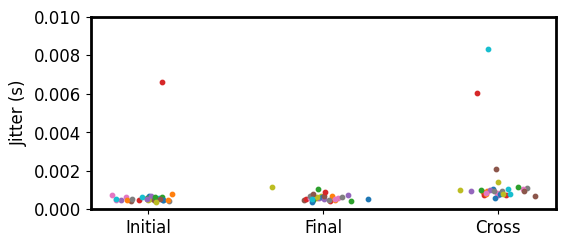

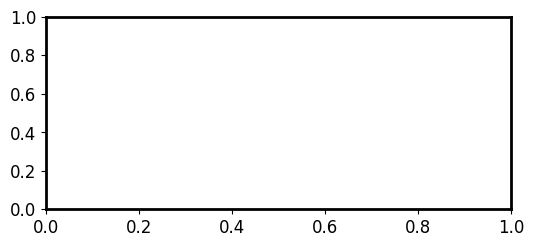

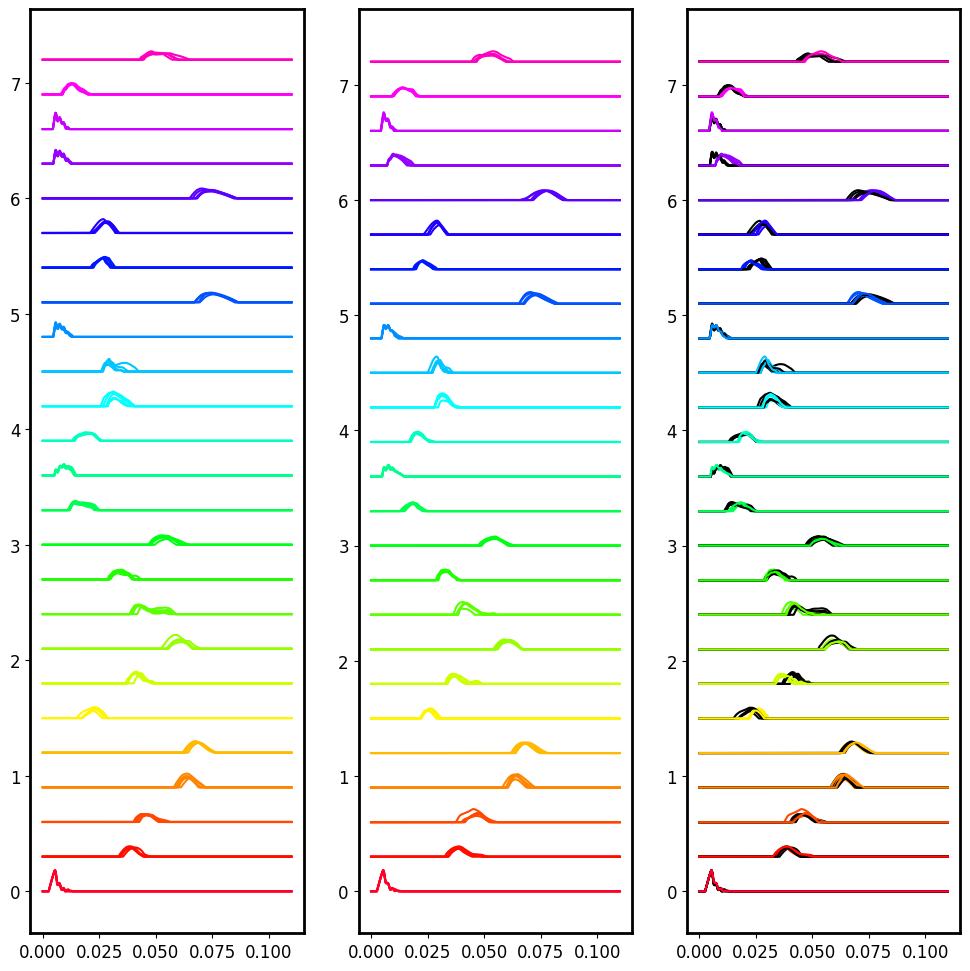

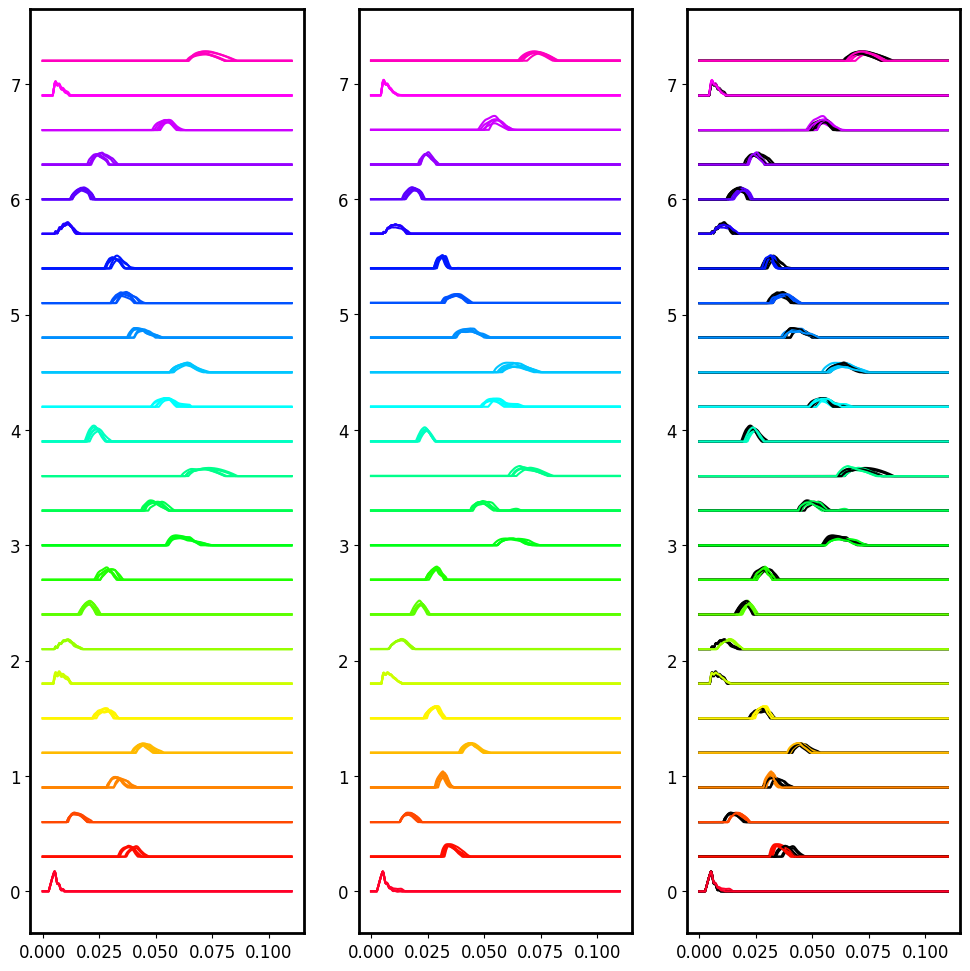

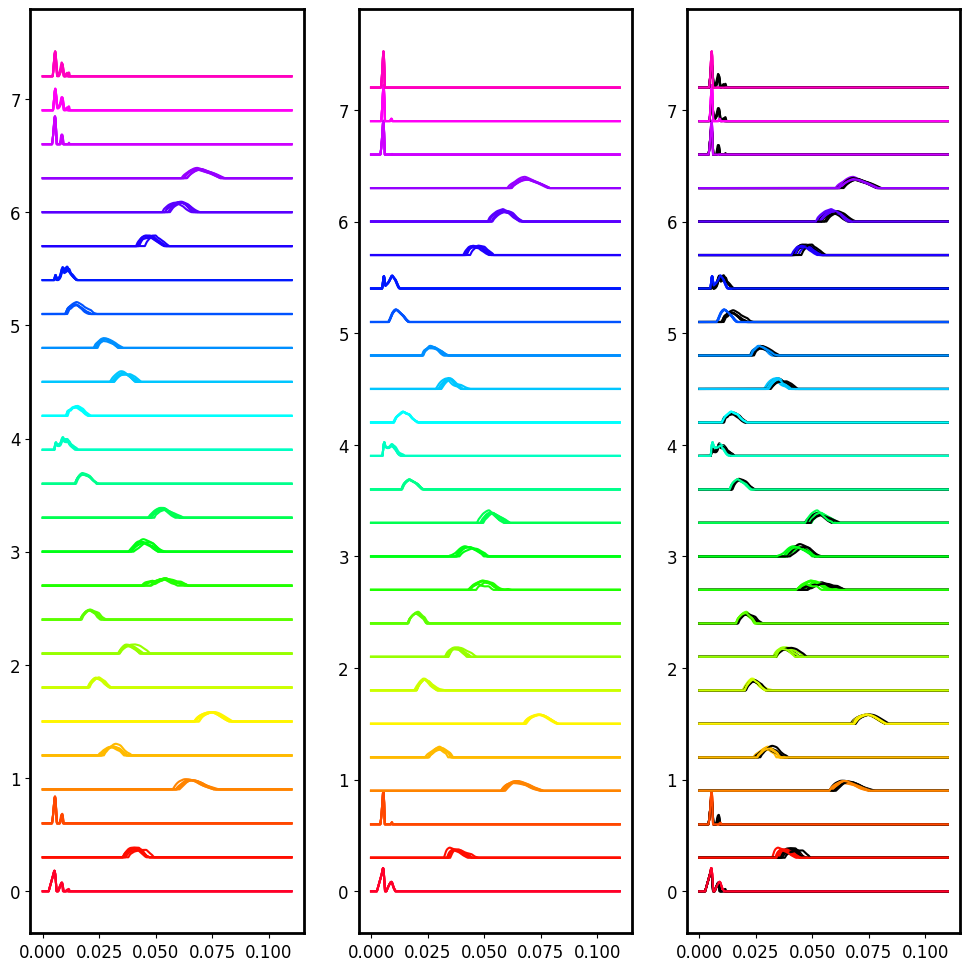

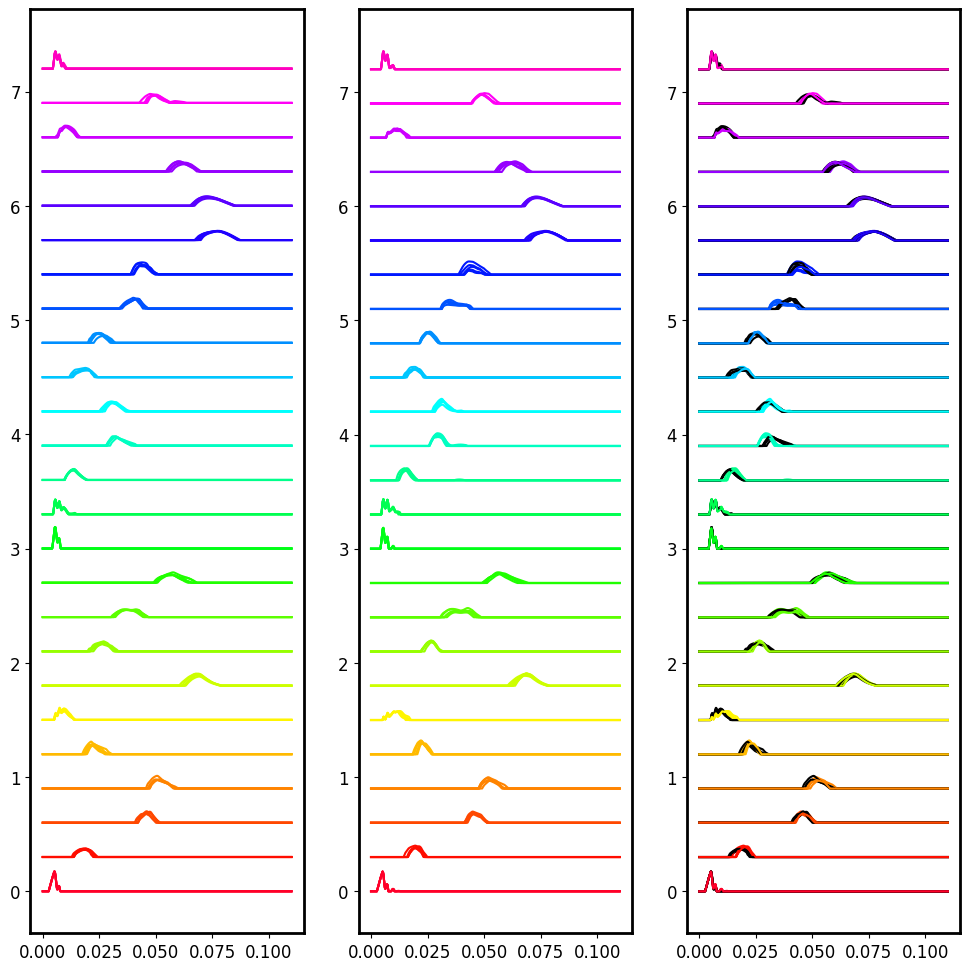

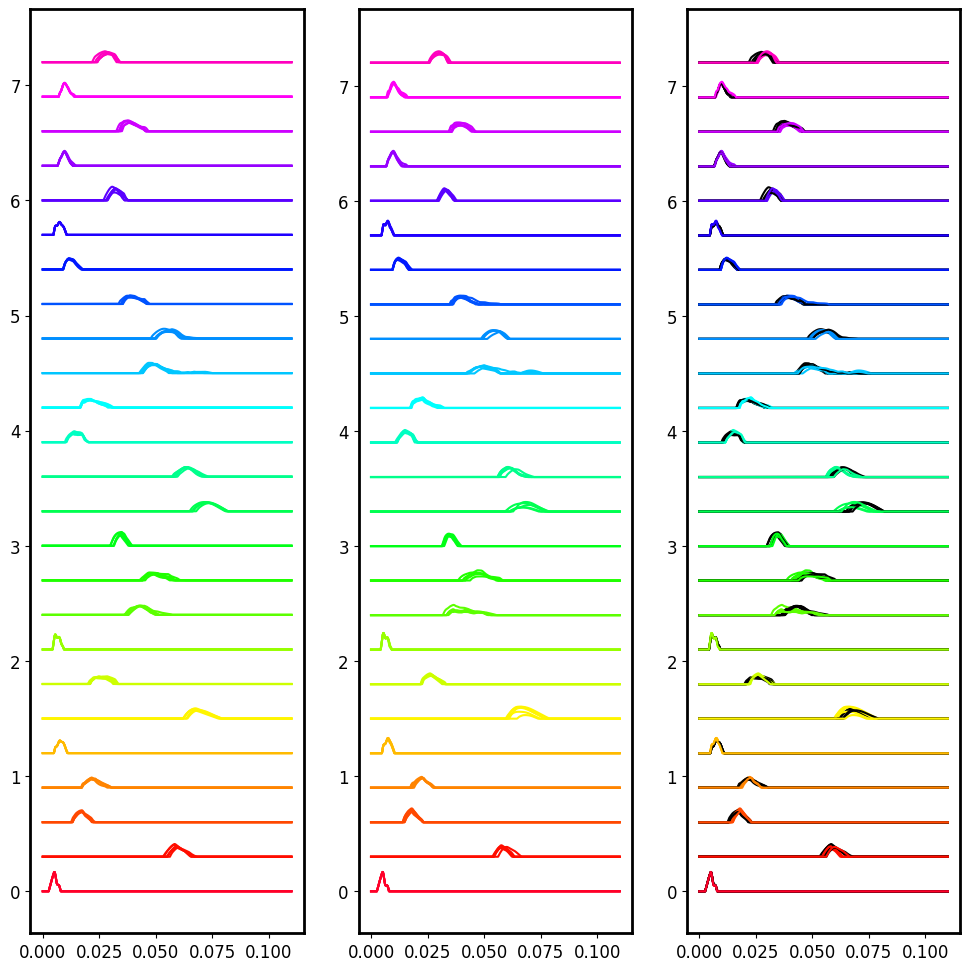

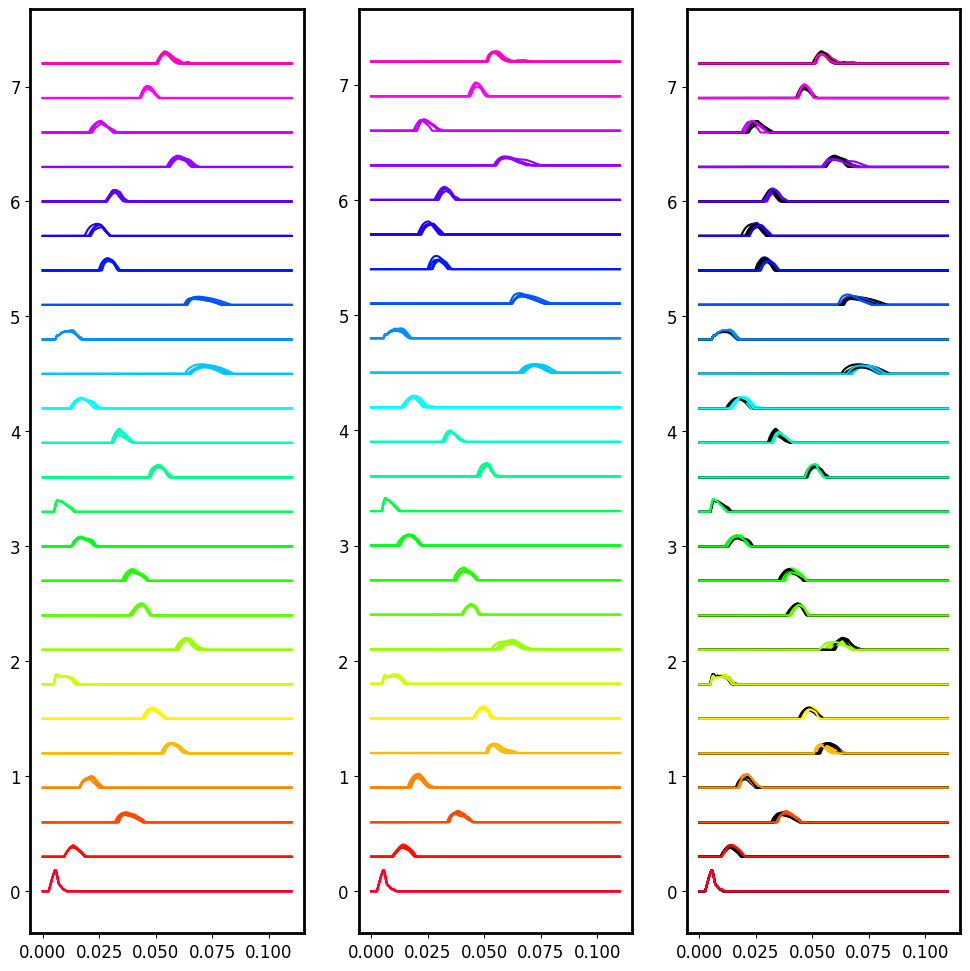

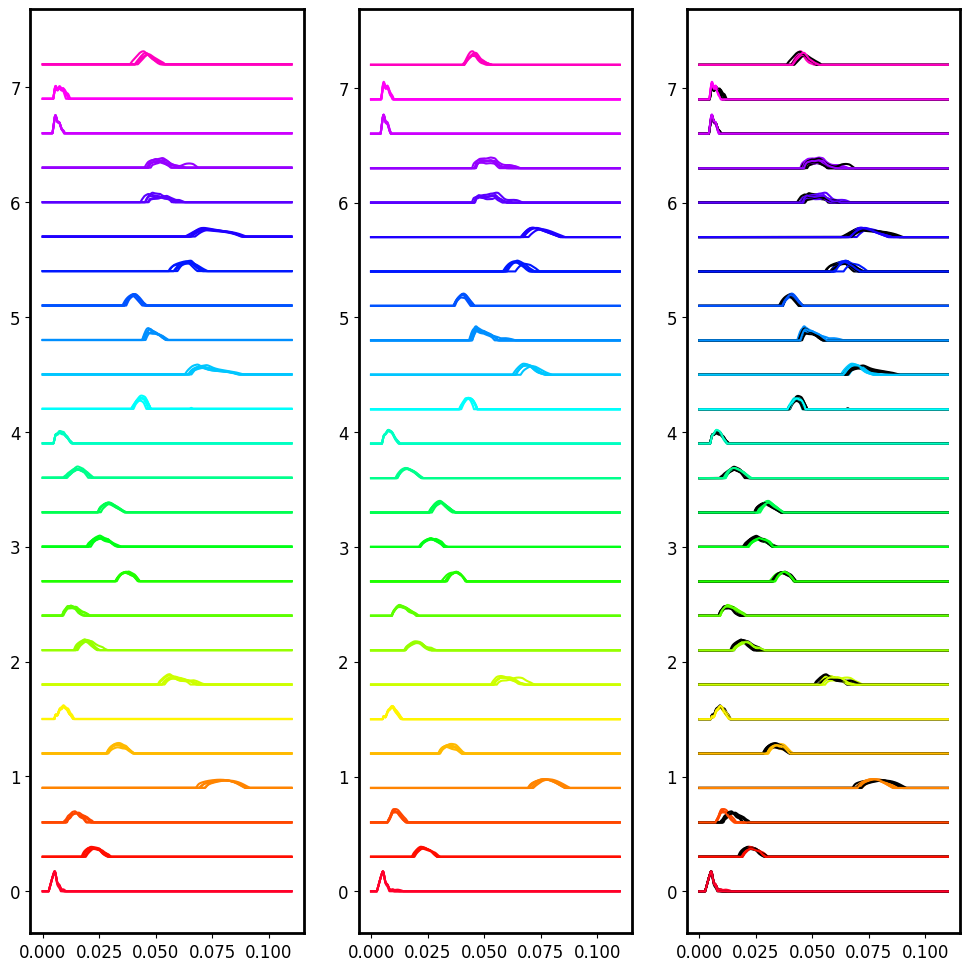

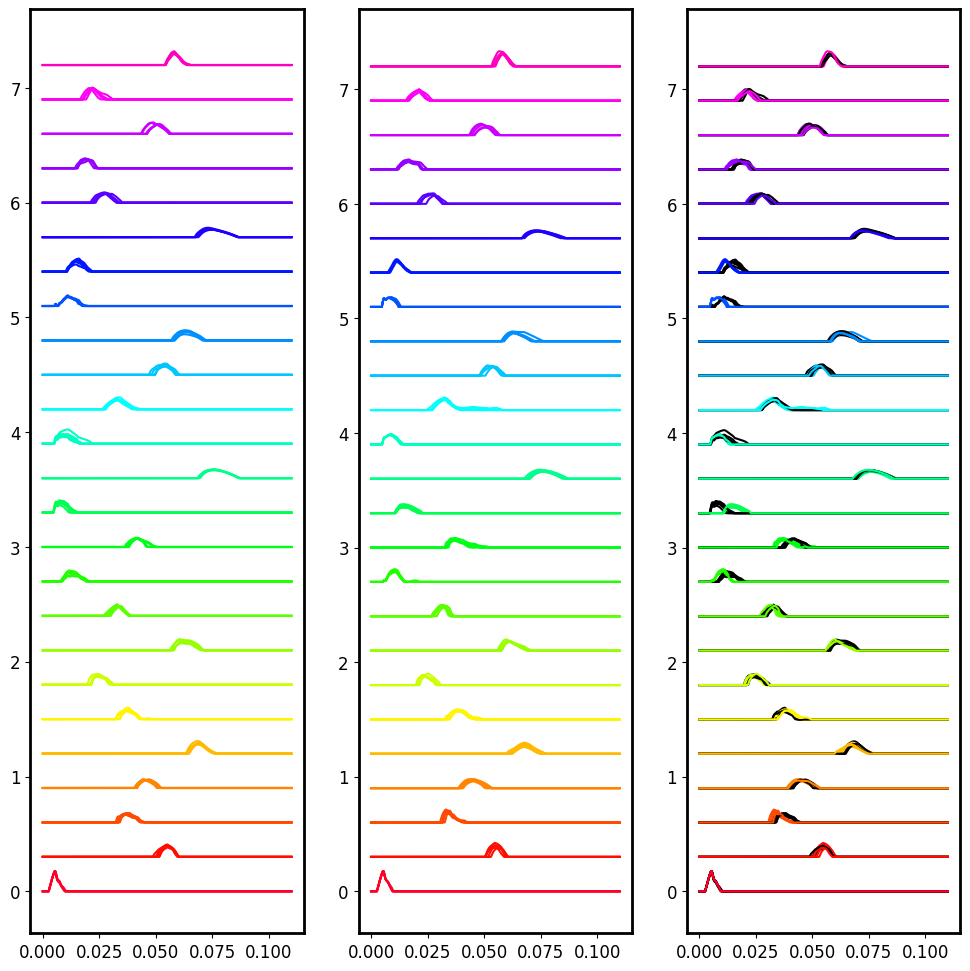

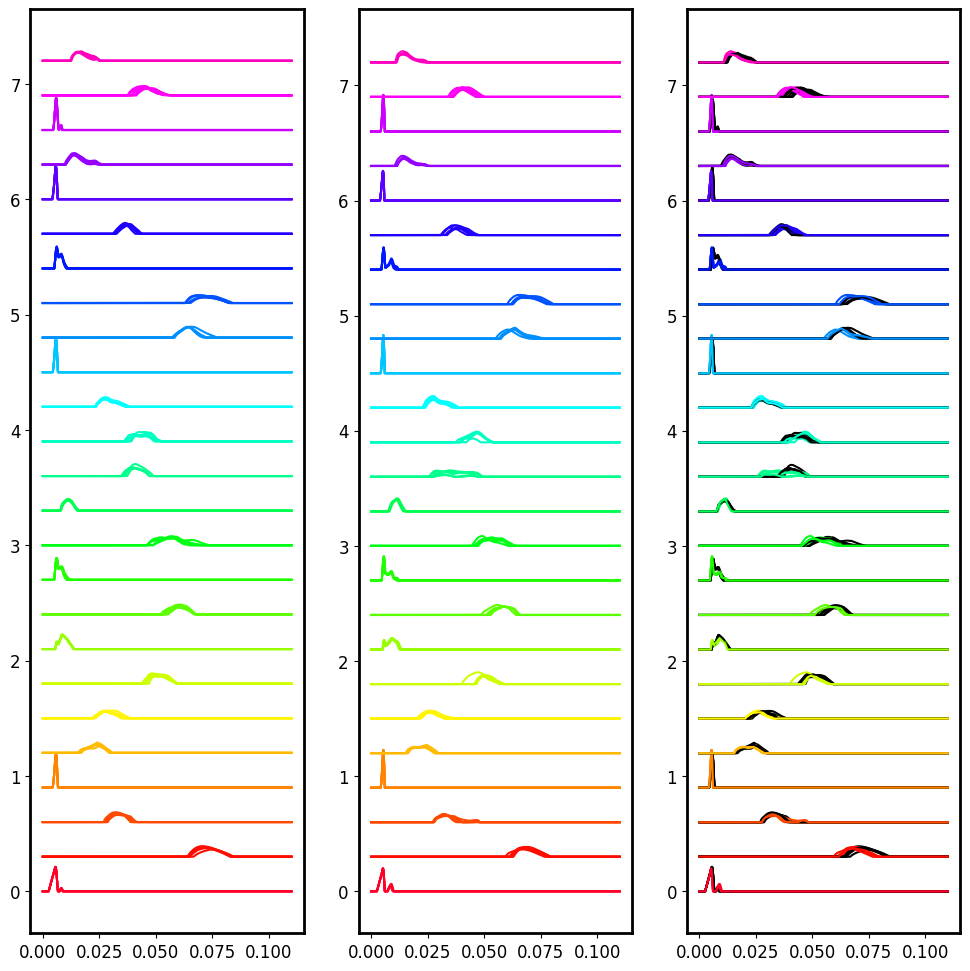

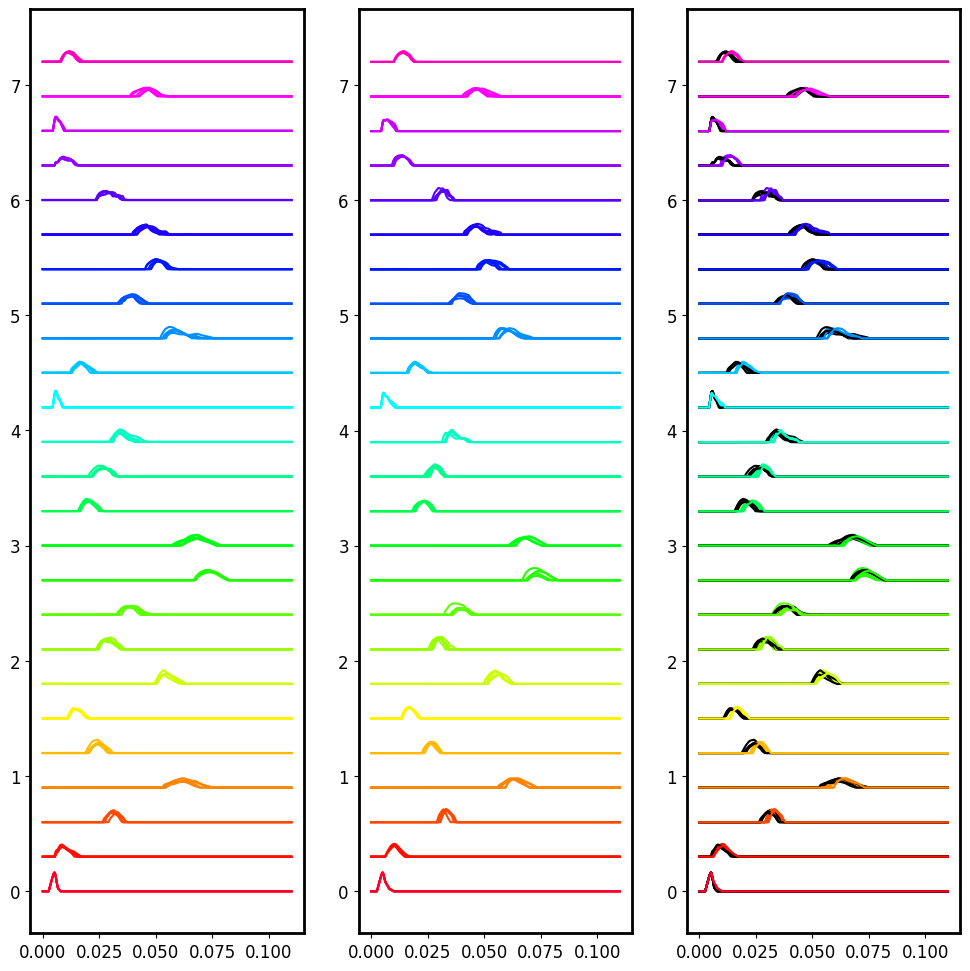

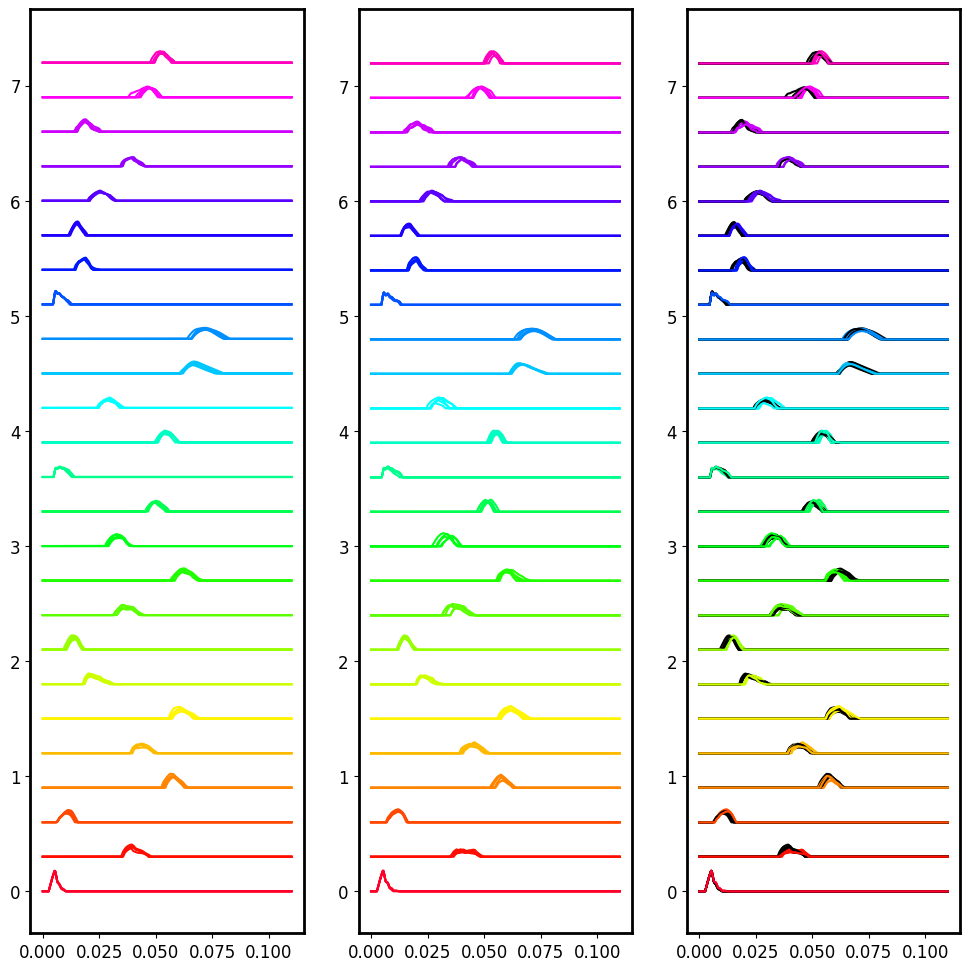

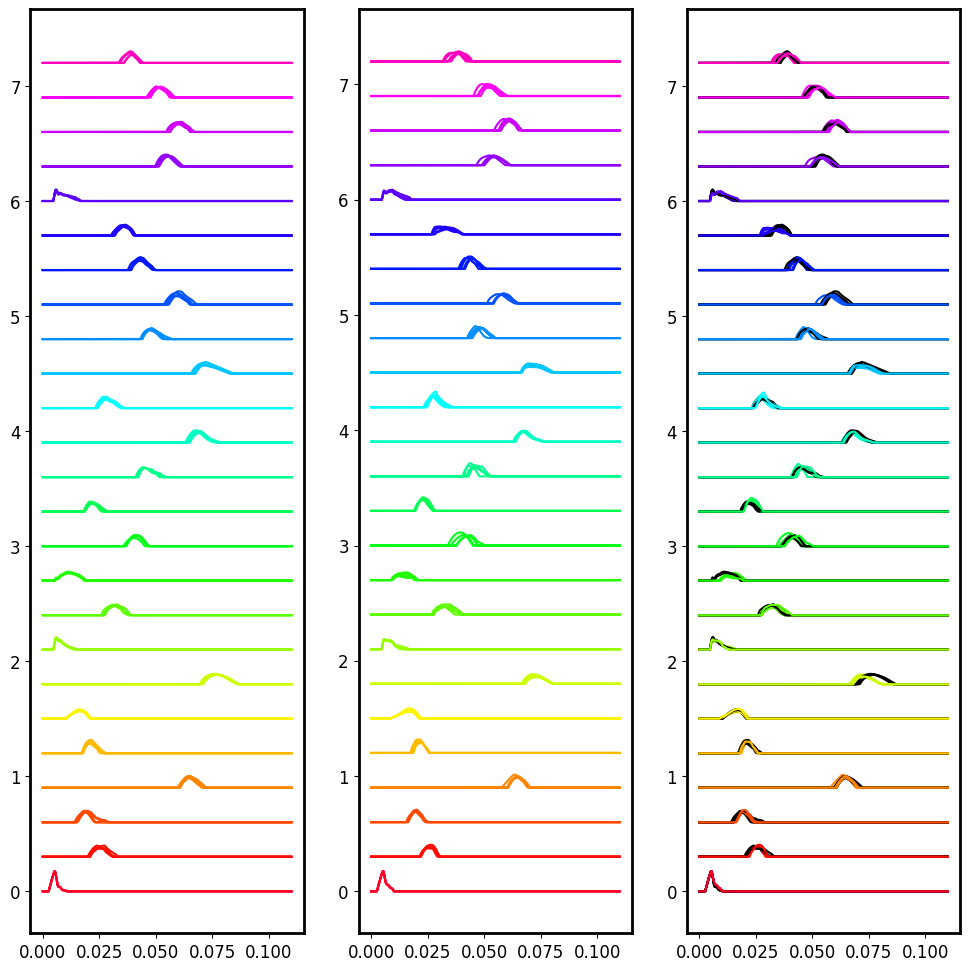

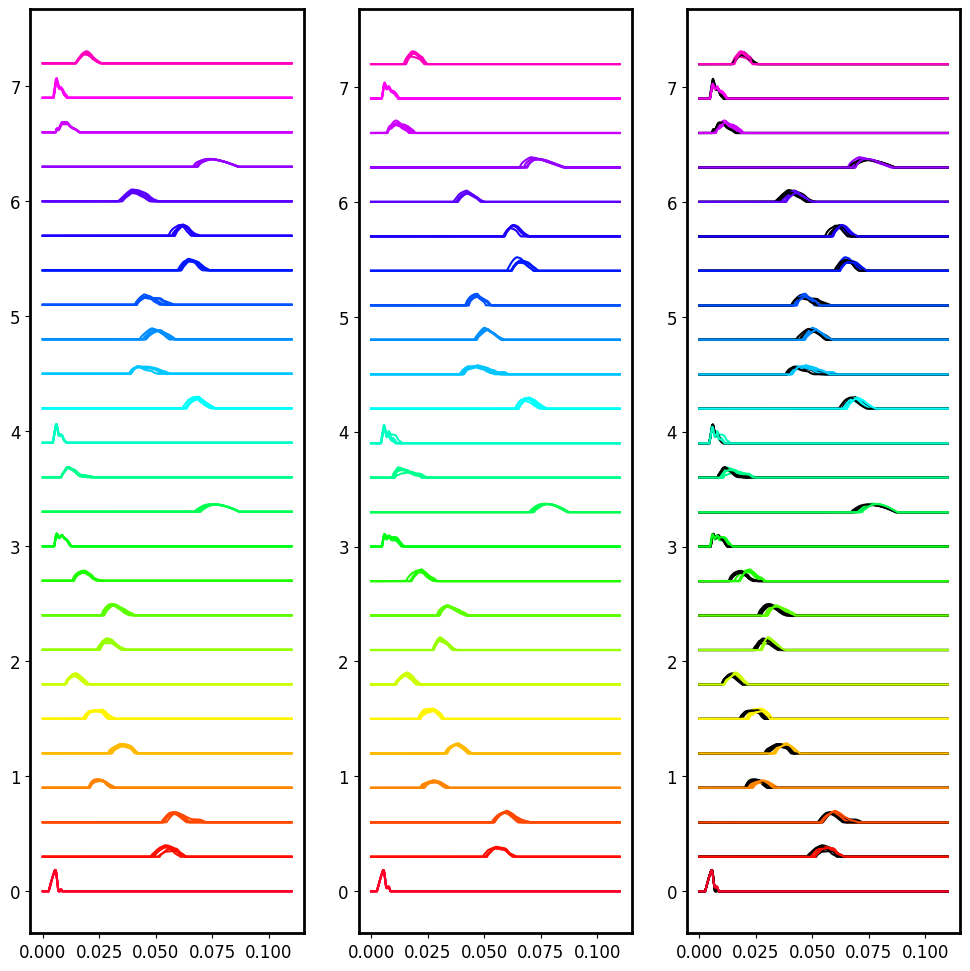

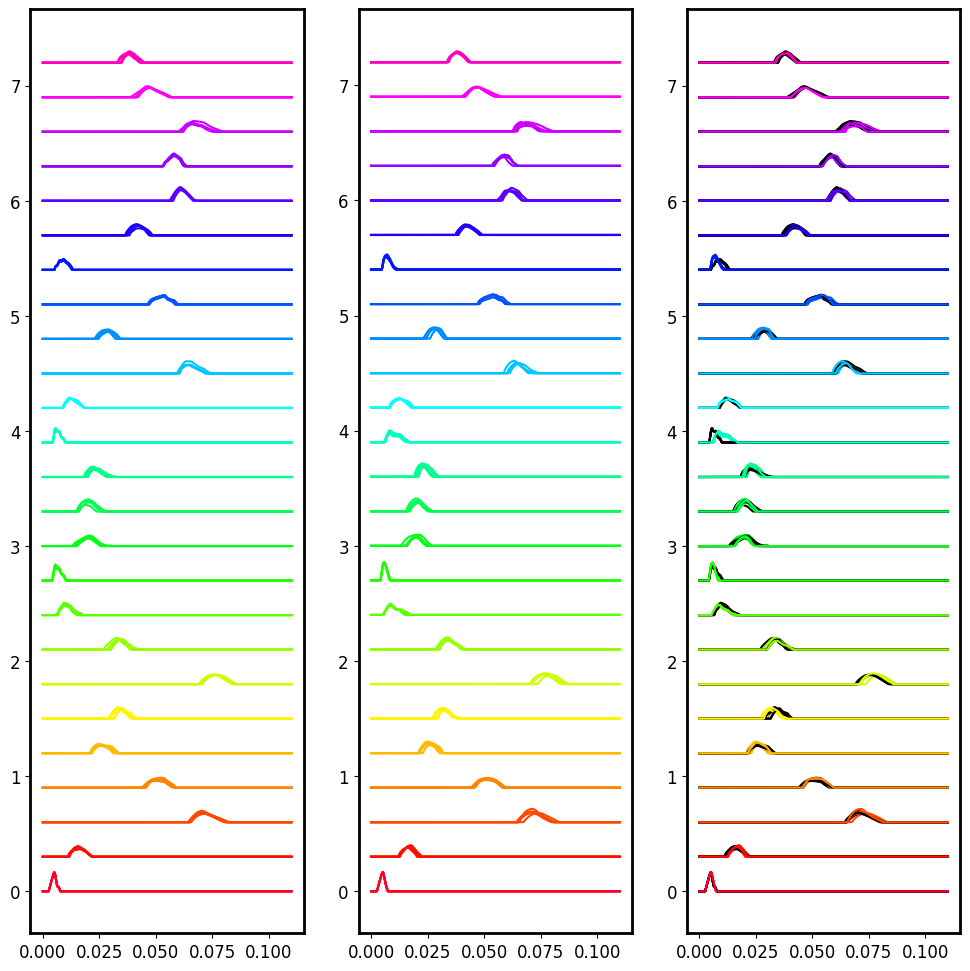

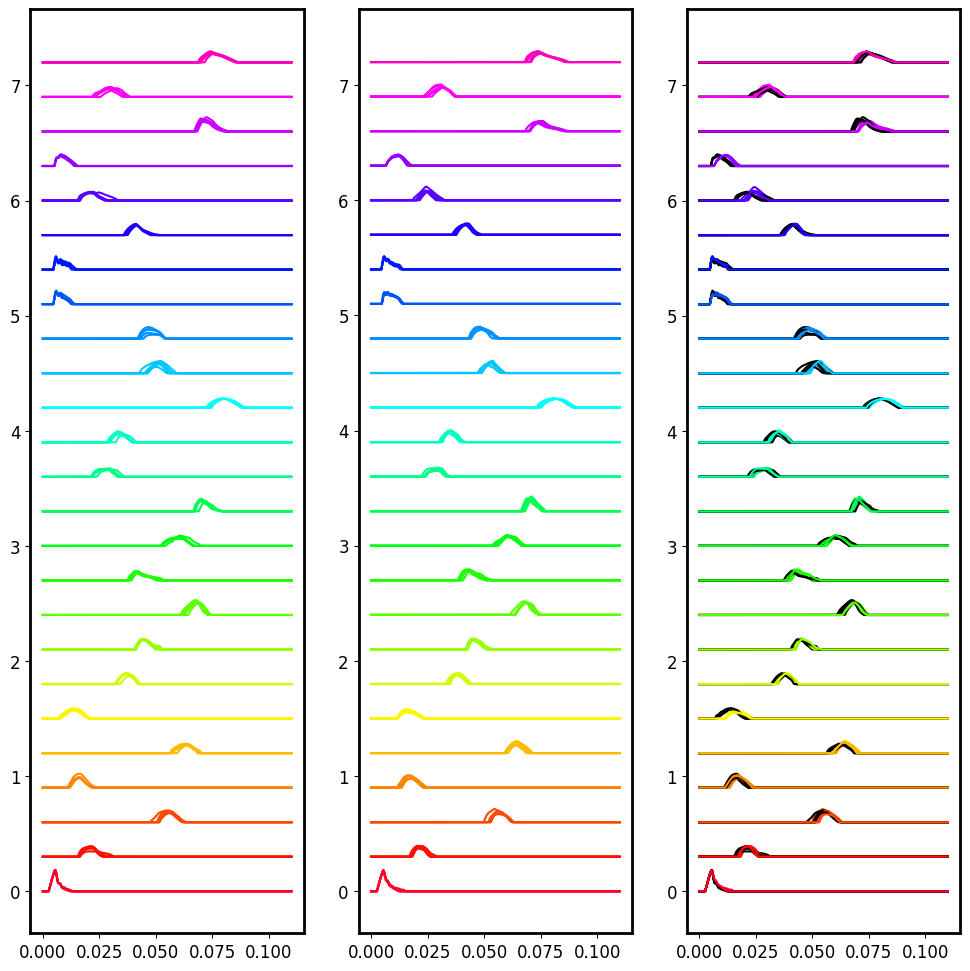

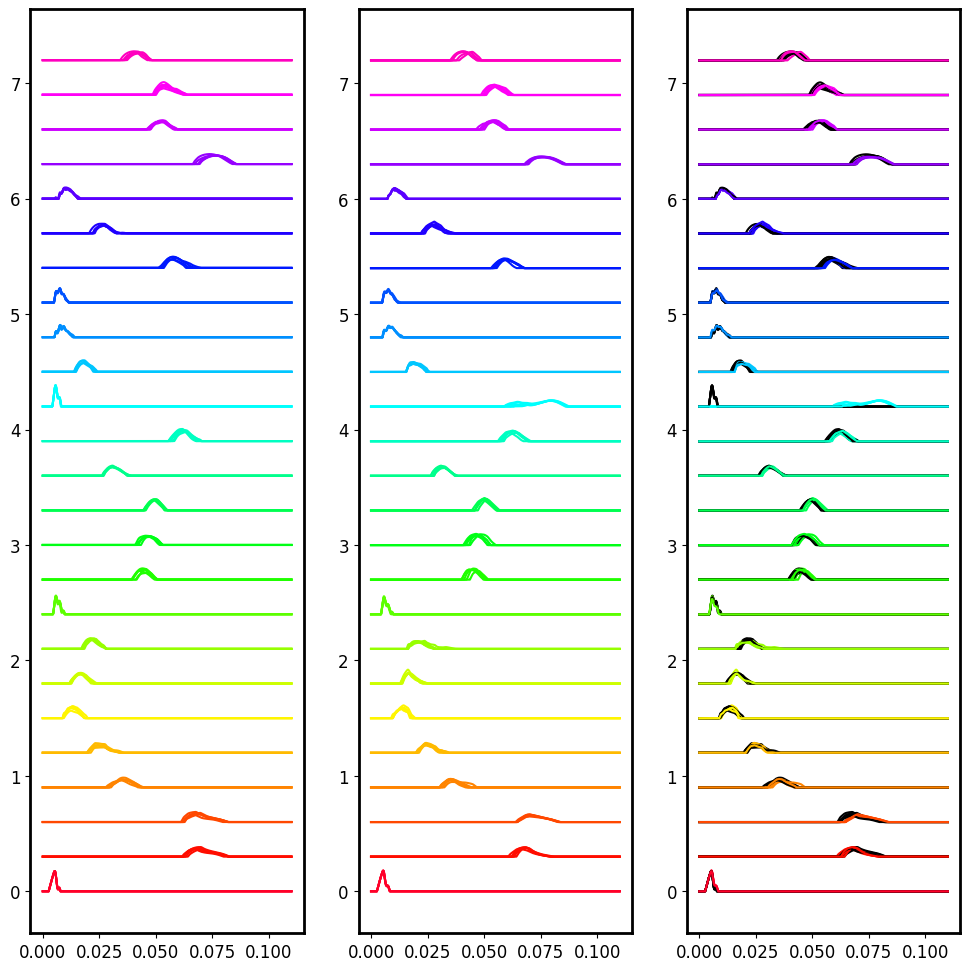

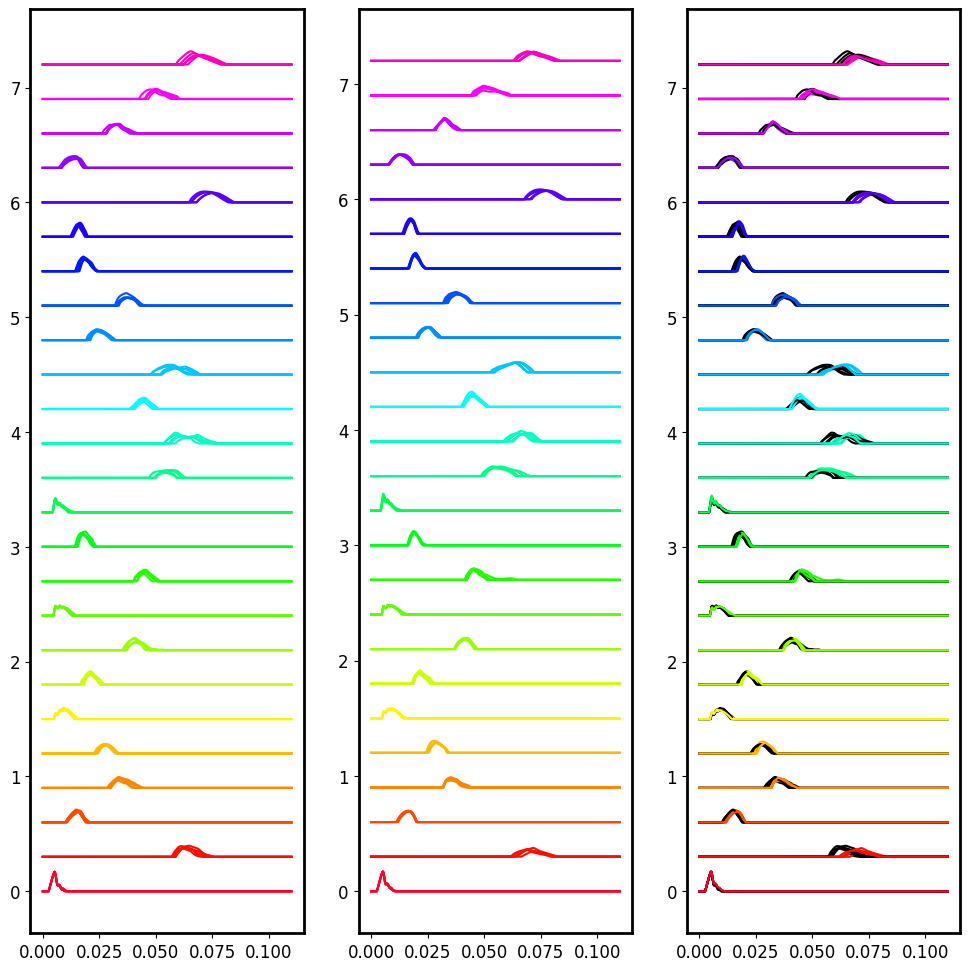

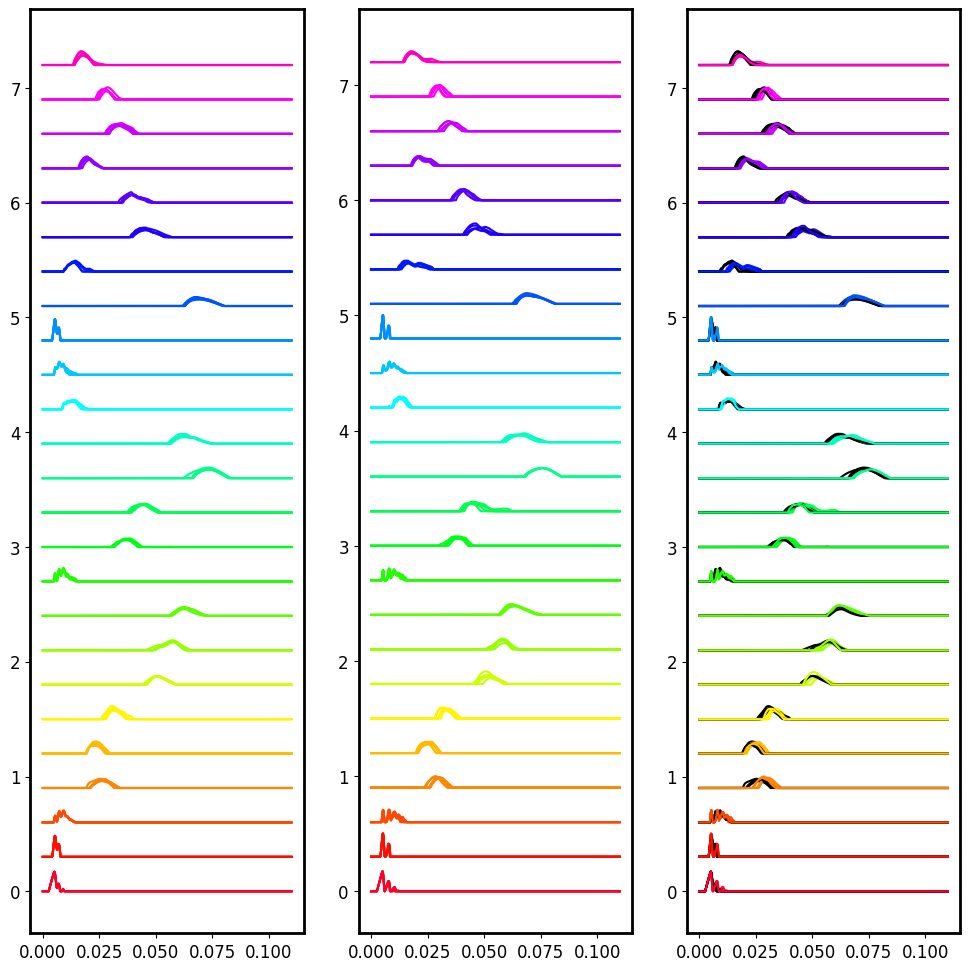

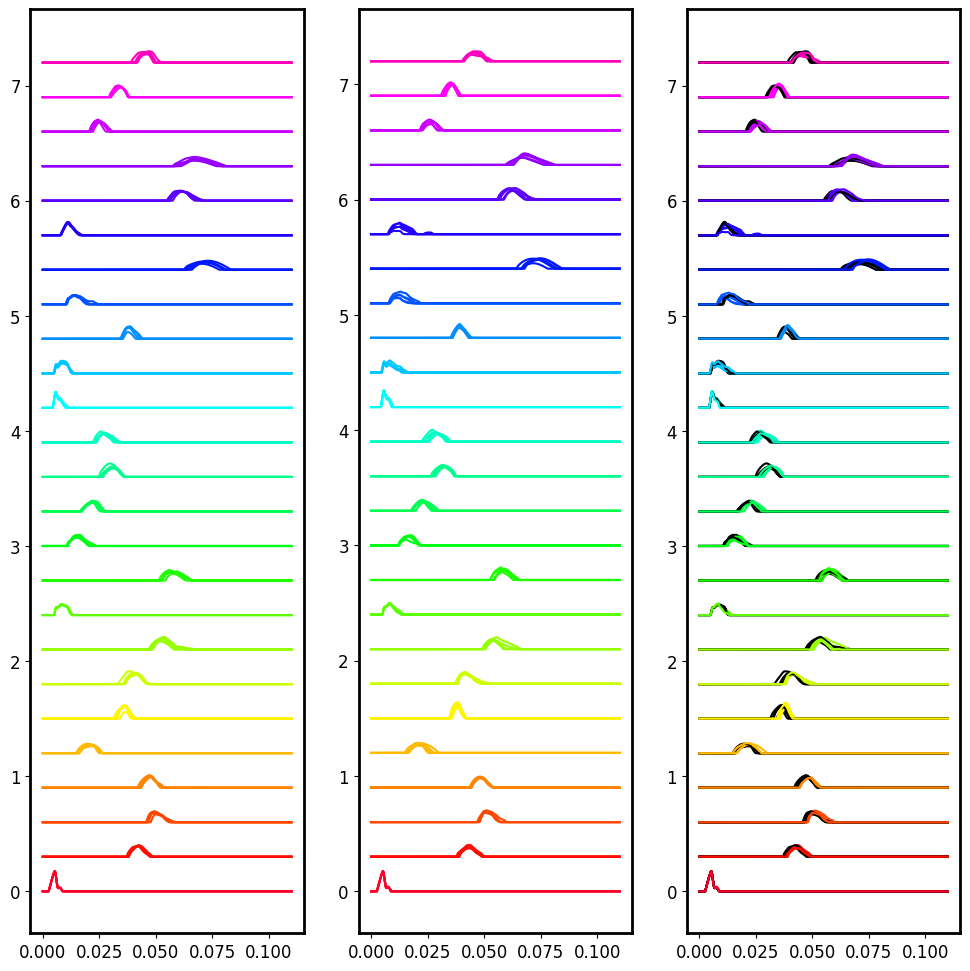

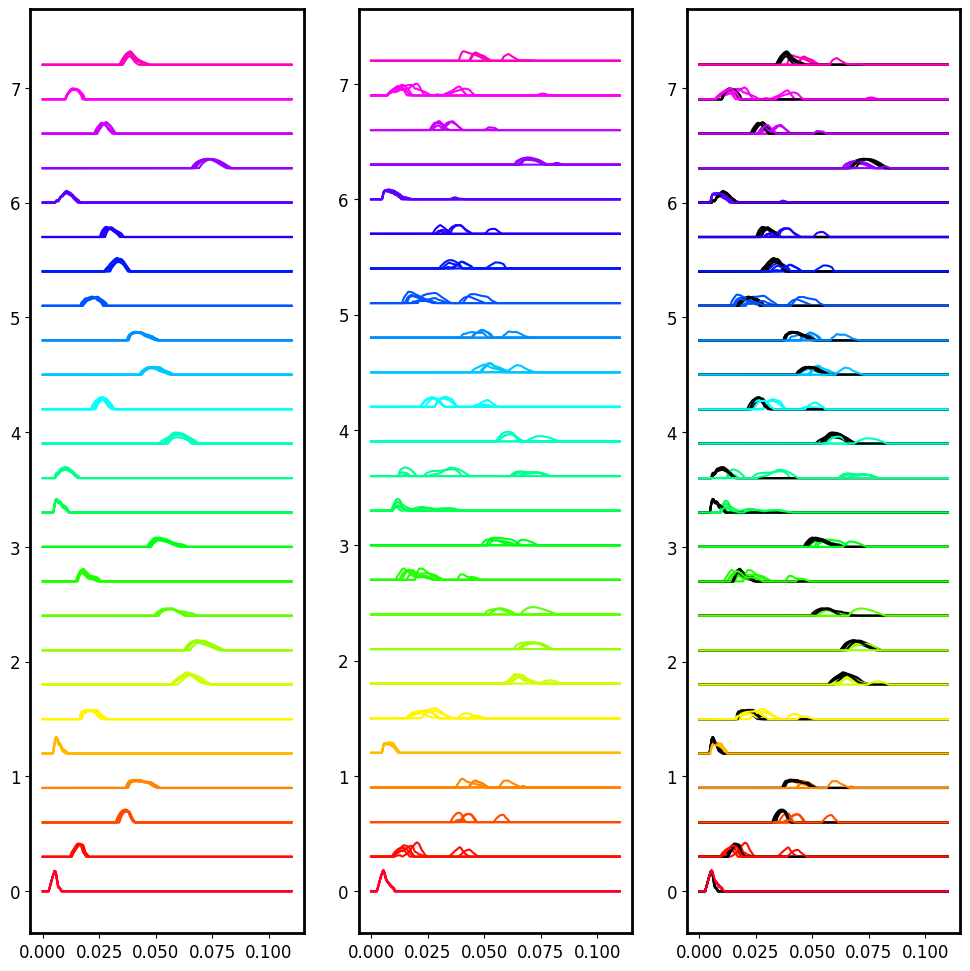

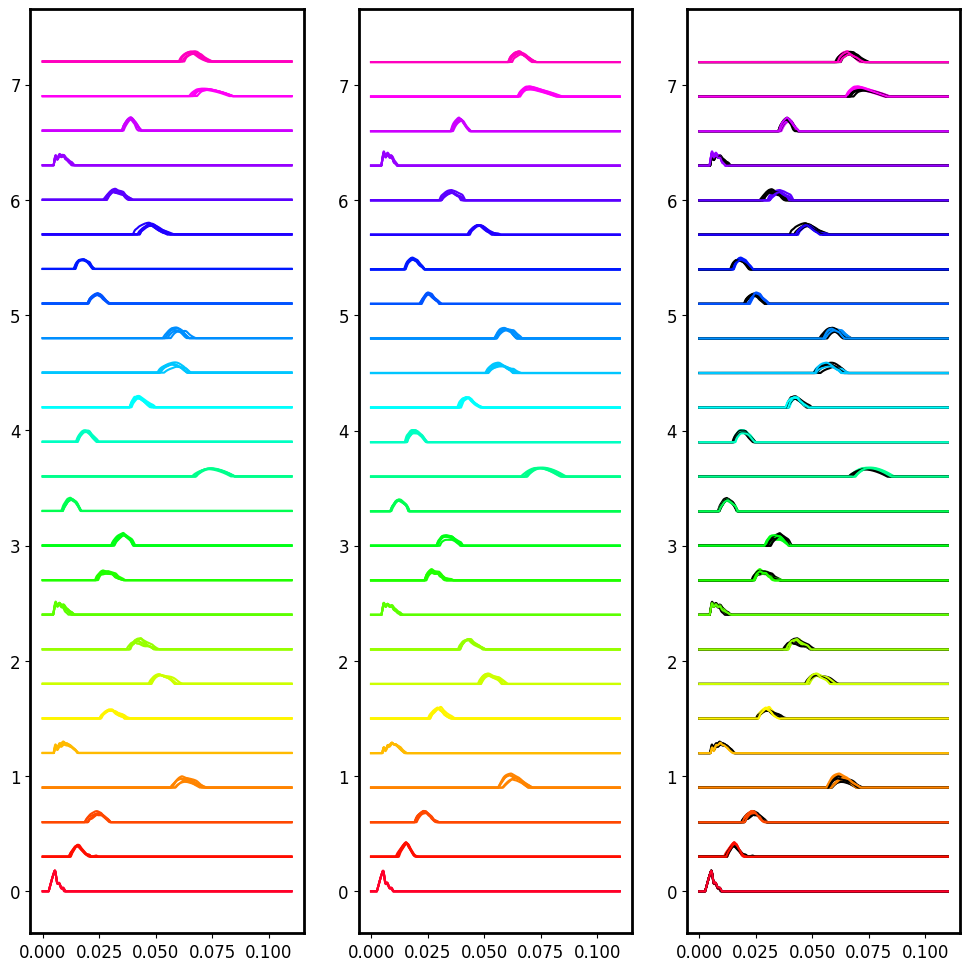

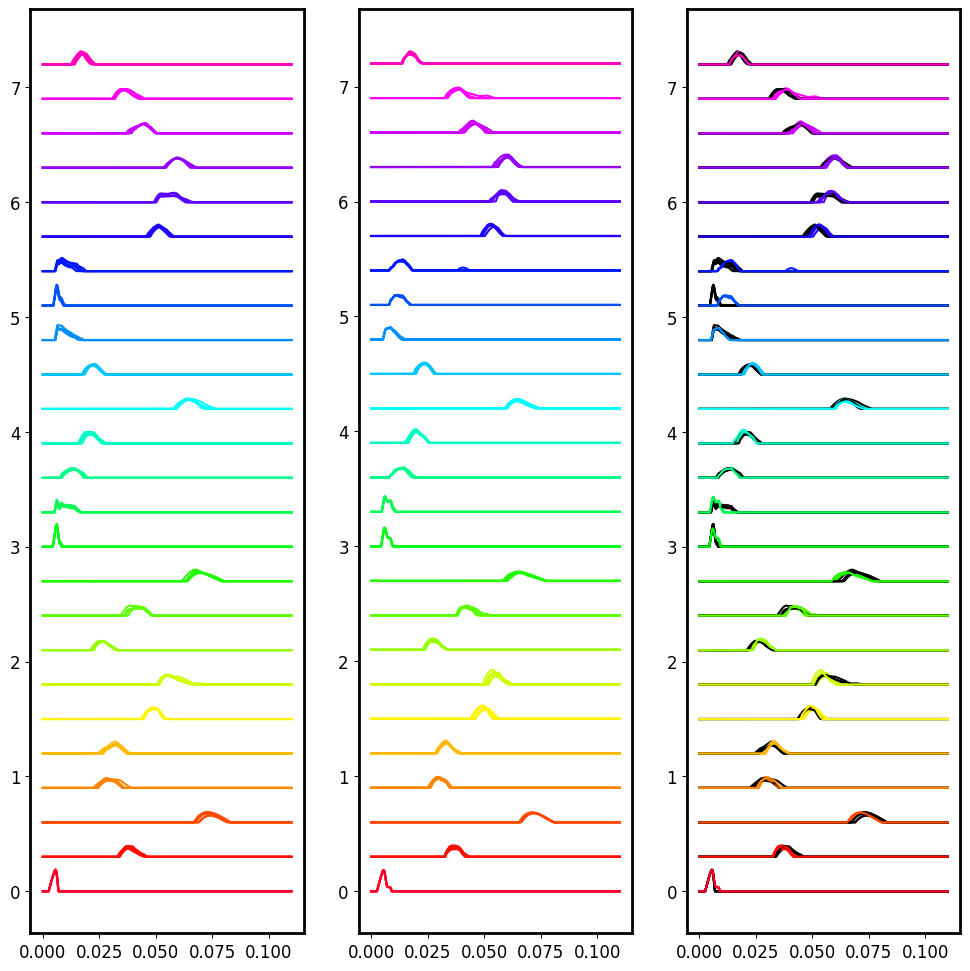

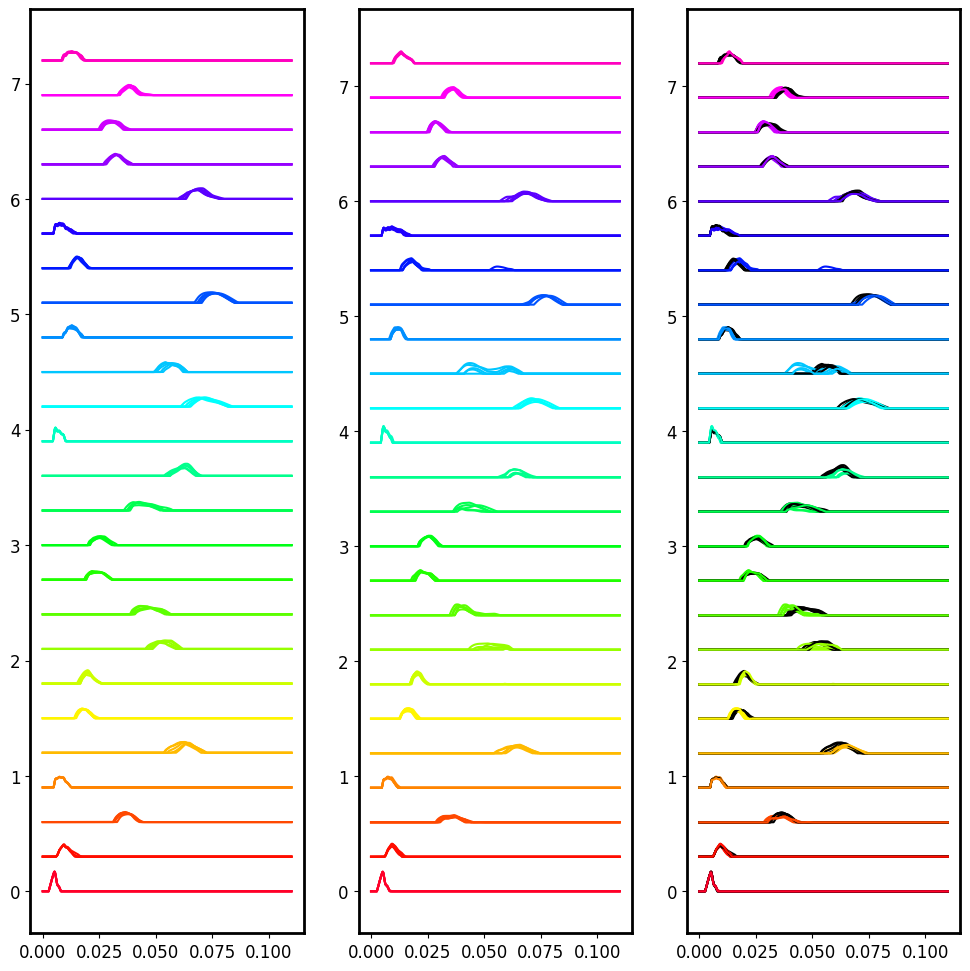

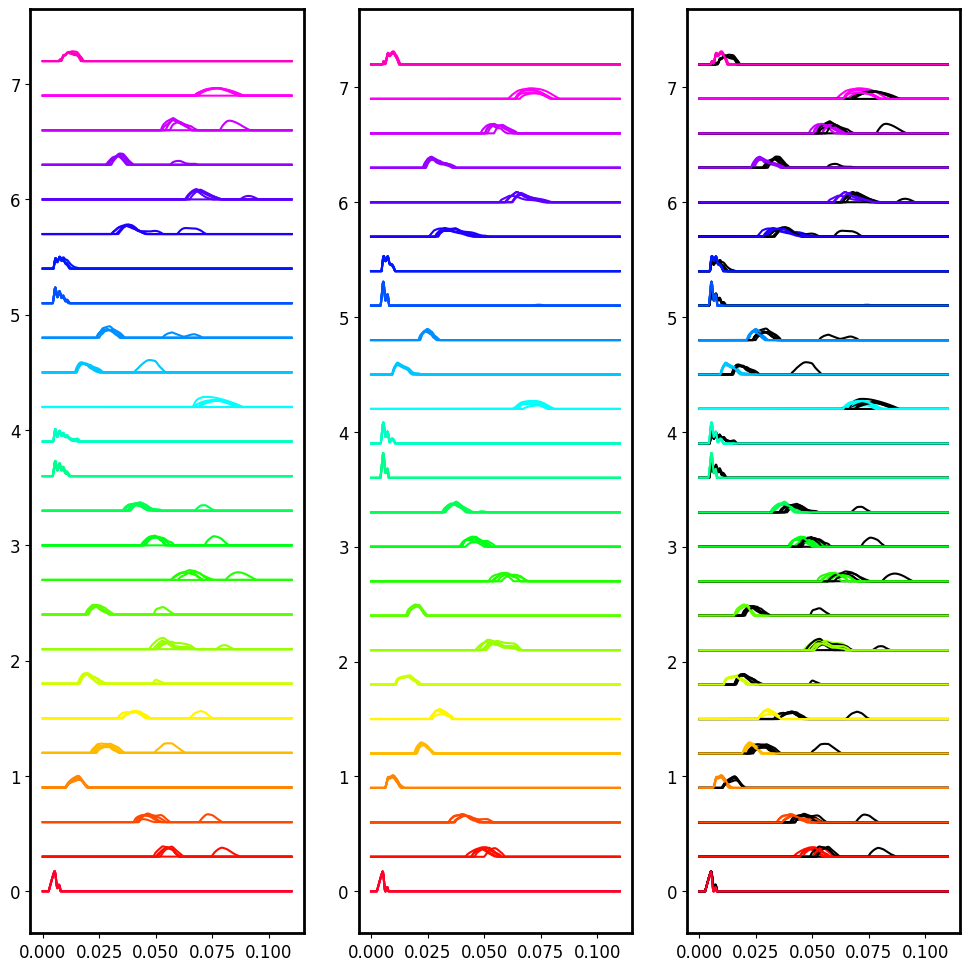

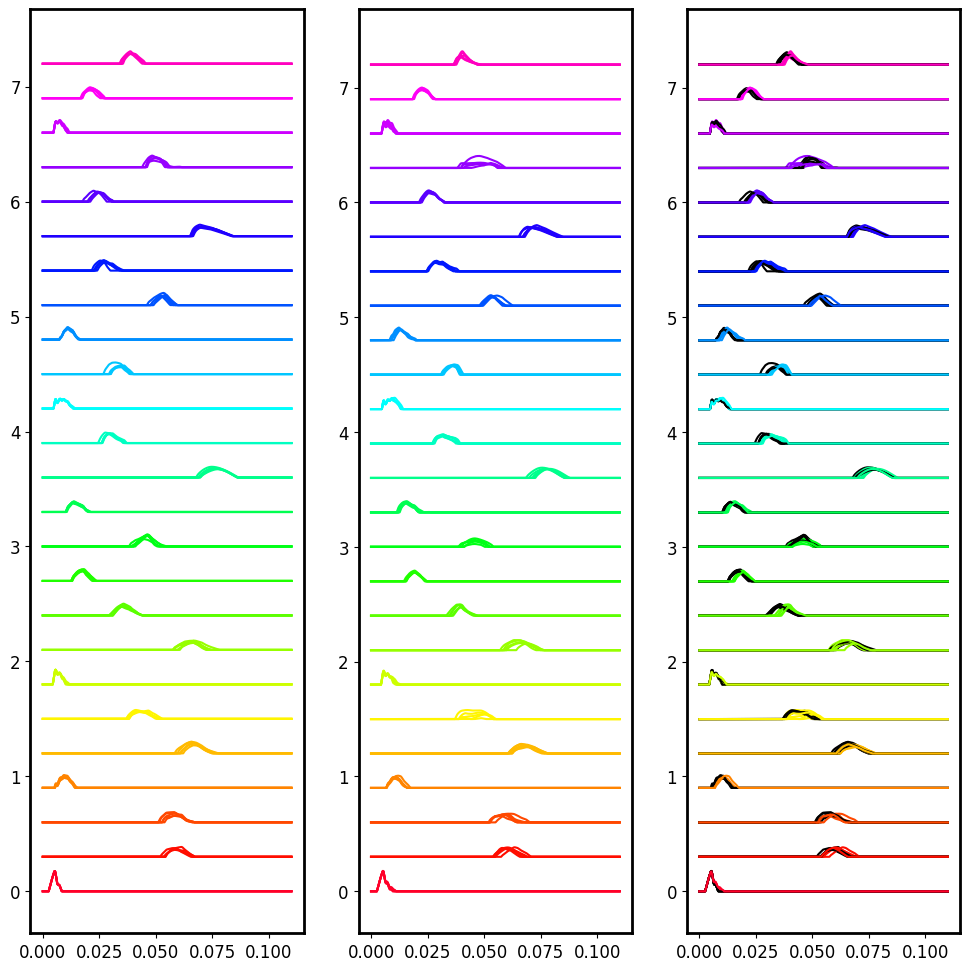

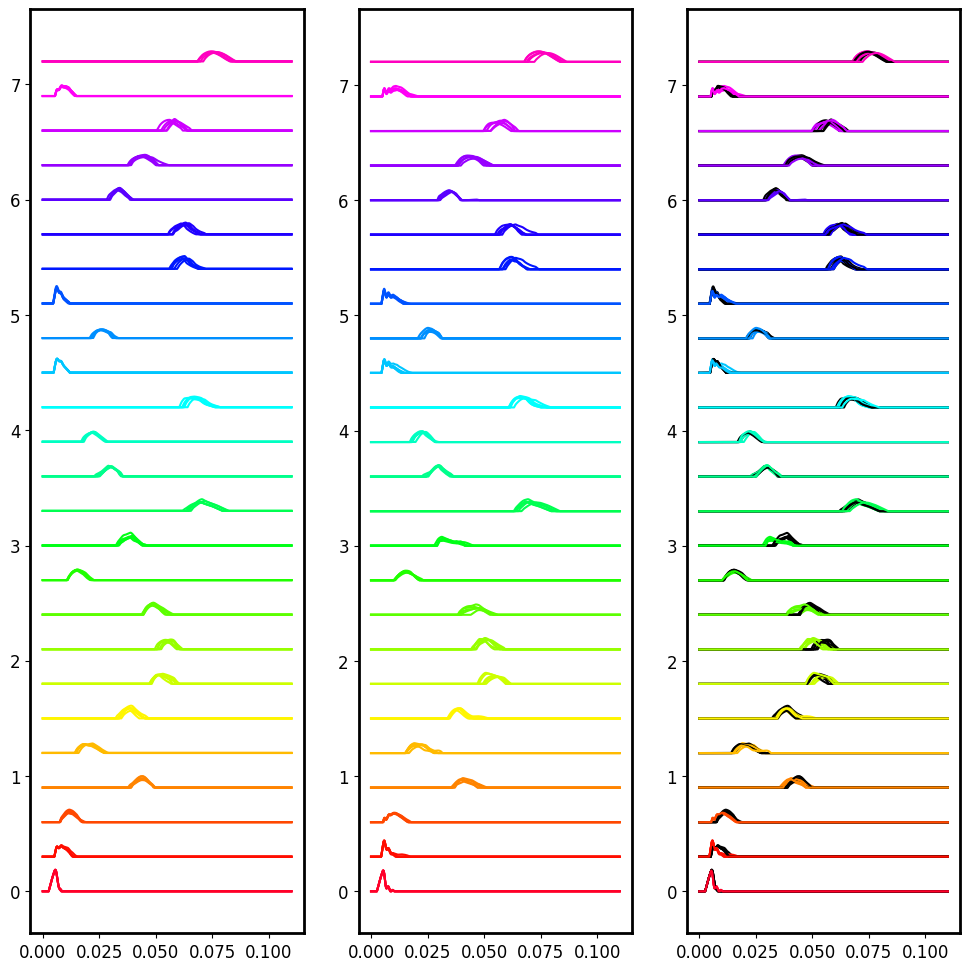

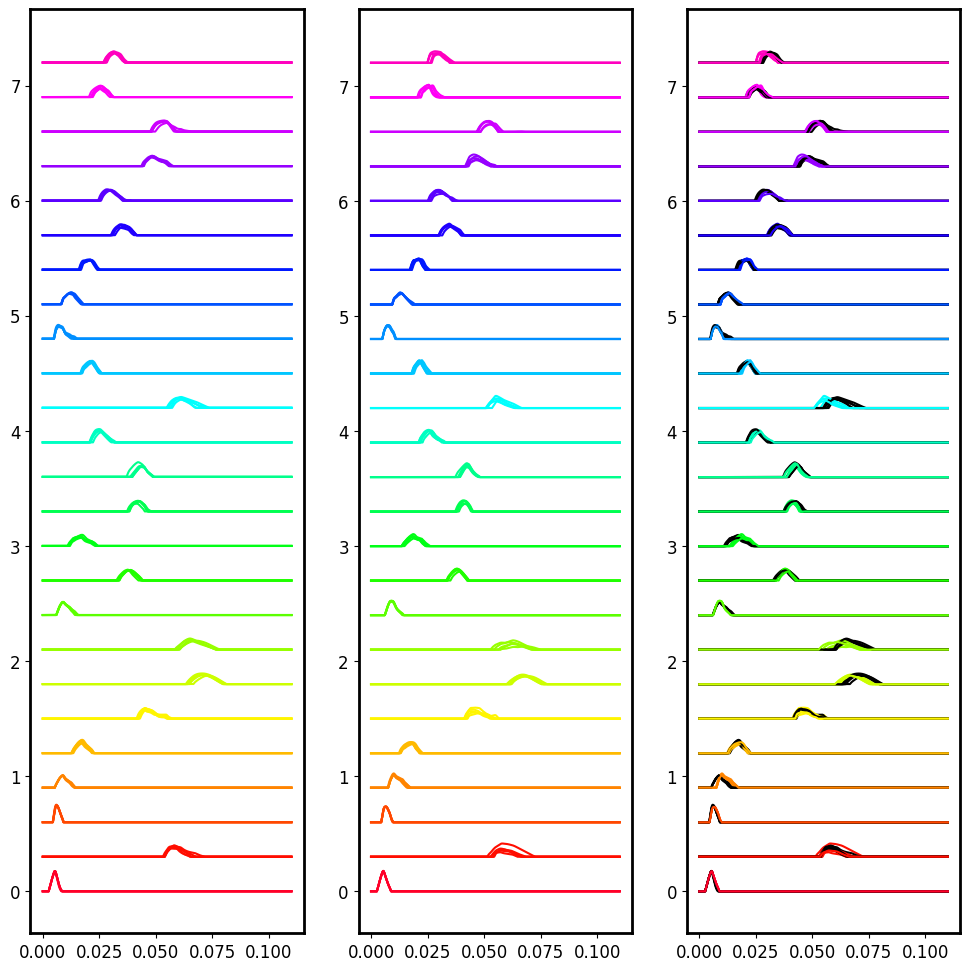

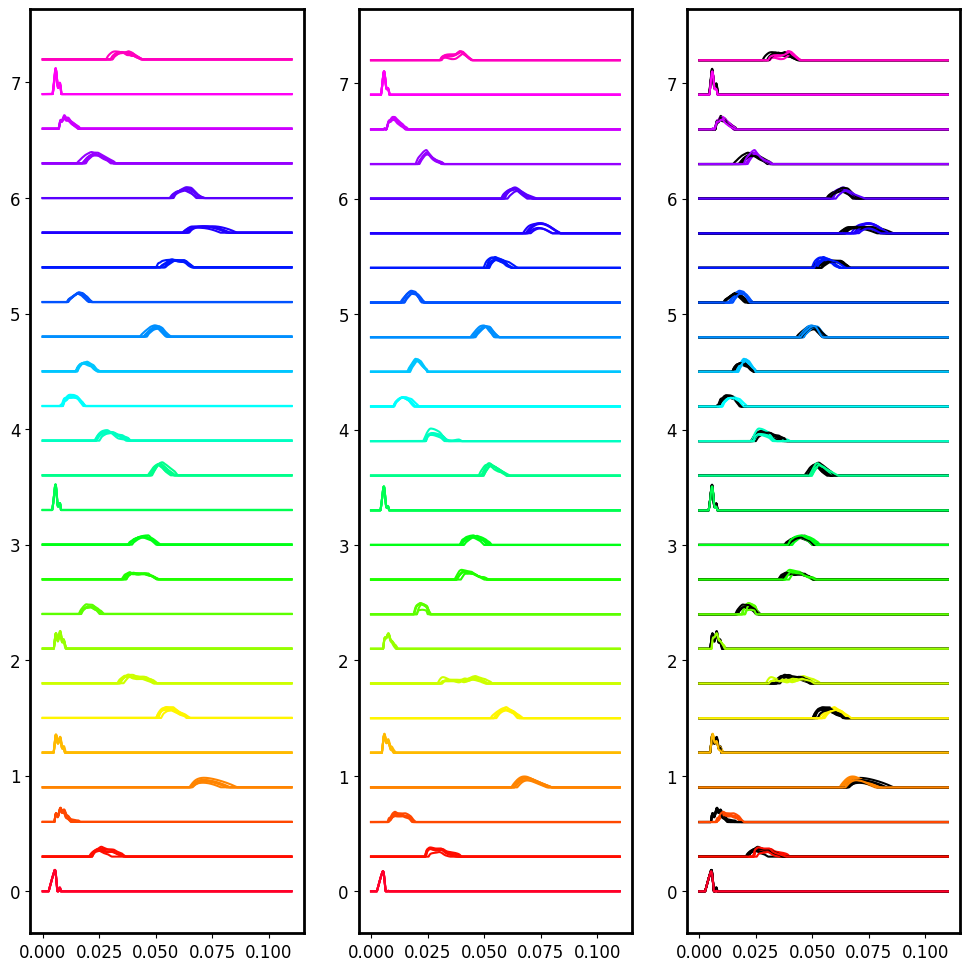

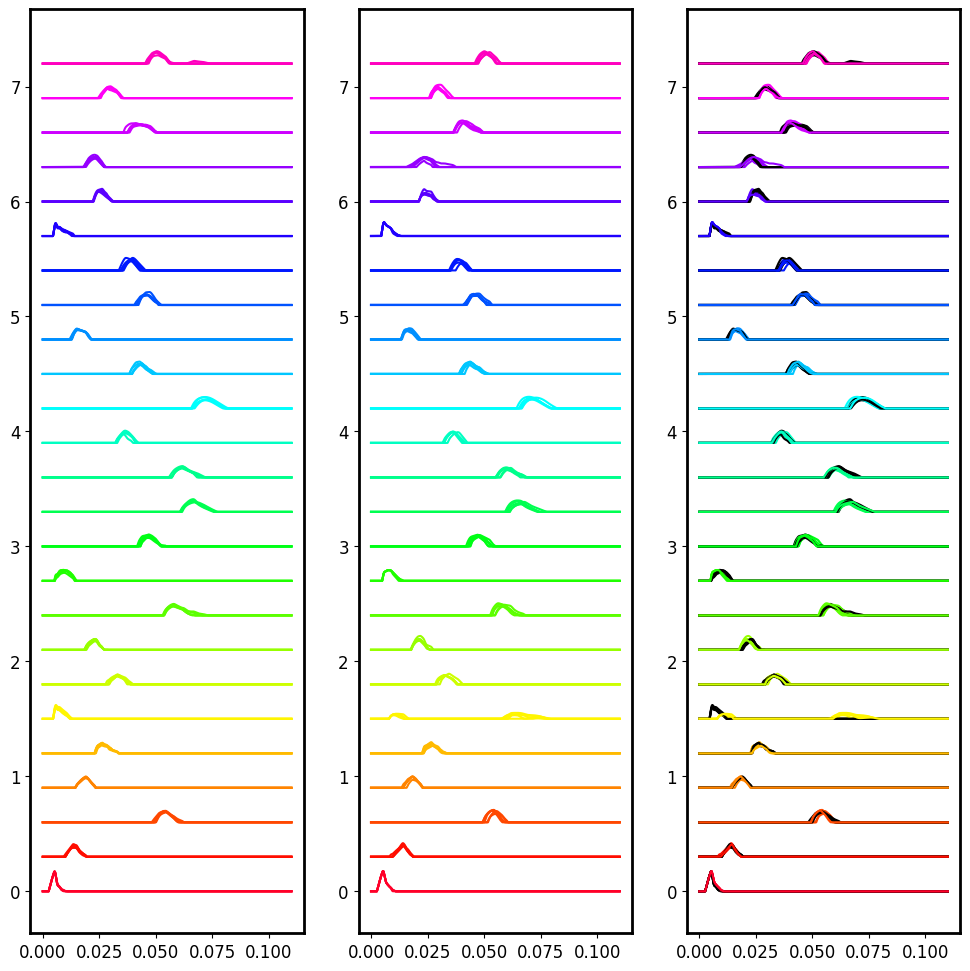

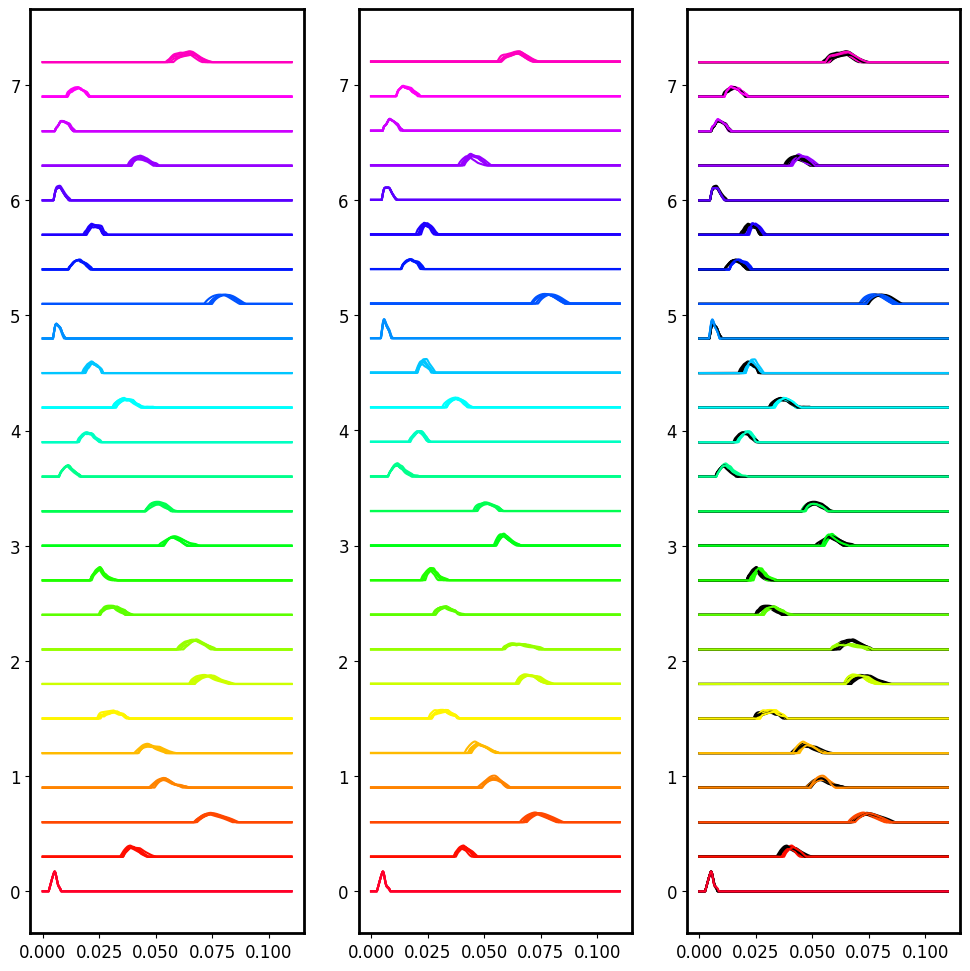

In [79]:
file_name = 'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00073_FRACI_0.75_SEED_503_2024-01-16_14:21:40.034539'
plot_activity([file_name], repeats=30)

In [16]:
def plot_kernel(file_names, x_range=None, n_indices=None):
    scale = 0.7
#     k_fig, k_axs = plt.subplots(1, 1, figsize=(6 * scale, 6 * scale), sharex=True, sharey=True)

    for f_idx, file_name in enumerate(file_names):

        for b_idx in range(5):
            saved_activities_path = f'{file_name}/all_r_{b_idx}.csv'
            try:
                all_r = read_csv(saved_activities_path, read_header=False, delimiter=',')
                all_r = np.array(all_r)

                time_steps_per_trial = int(all_r.shape[0] / 12)
                
                for trial_idx in range(6, 12):
                    r = all_r[time_steps_per_trial * trial_idx: time_steps_per_trial * (trial_idx + 1), :]
                    r_summed = np.sum(r, axis=0)
                    r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
                    r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
                    r_normed = r / r_summed_safe_divide
                    t = np.arange(r.shape[0]) * 1e-4 * 1e3
                    t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=0)
                    t_means[t_means == 0] = np.nan
                    t_ordering = np.argsort(t_means)
                    
#                 scale = 1
#                 fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
#                 axs.matshow(w[:40, :40], cmap='bwr', vmax=5, vmin=-5)
            except FileNotFoundError as e:
                pass
            
            saved_weights_path = f'{file_name}/weight_mat_{b_idx}.csv'
            try:
                w = read_csv(saved_weights_path, read_header=False, delimiter=',')
                w = np.array(w)
                sorted_w = w[:40, :40][t_ordering, :][:, t_ordering]

                kernel = extract_kernel(w[:40, :40])

                fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
                axs.matshow(sorted_w, cmap='bwr', vmax=5, vmin=-5)
                axs.set_xlabel('Cell index')
                axs.set_ylabel('Cell index')
                axs.set_xticks([0, 40])
                axs.set_xticklabels([0, 40])
                axs.set_yticks([0, 40])
                axs.set_yticklabels([0, 40])
                
                time_diffs = []
                weights_for_time_diffs = []
                for t_idx_i, t_mean_i in enumerate(t_means):
                    for t_idx_j, t_mean_j in enumerate(t_means):
                        if not np.isnan(t_mean_i) and not np.isnan(t_mean_j) and (n_indices is None or (t_idx_j in n_indices)):
                            time_diffs.append(t_mean_j - t_mean_i)
                            weights_for_time_diffs.append(w[t_idx_j, t_idx_i])
                    
                fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
                axs.scatter(time_diffs, weights_for_time_diffs, s=10, marker='o', facecolor='none', edgecolor='black')
                axs.set_xlabel(r'$\Delta t_{ij}$ (ms)')
                axs.set_ylabel(r'$w_{ij}$')
                
                if x_range is not None:
                    axs.set_xlim(*x_range)
                
            except FileNotFoundError as e:
                pass

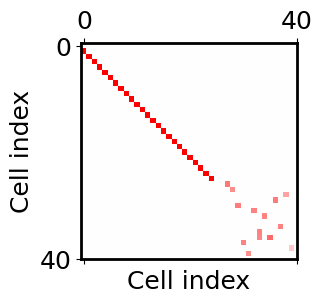

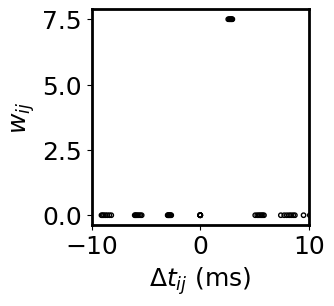

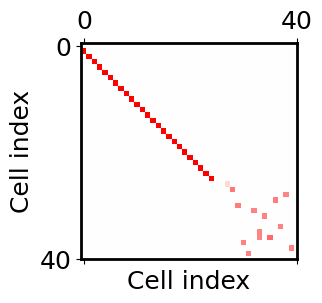

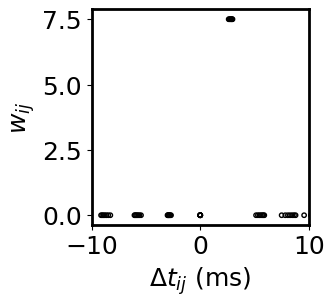

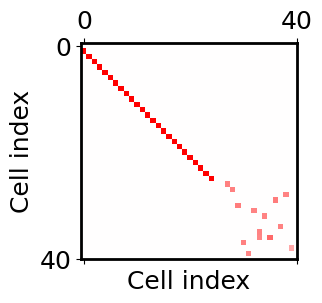

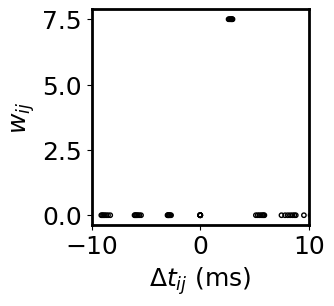

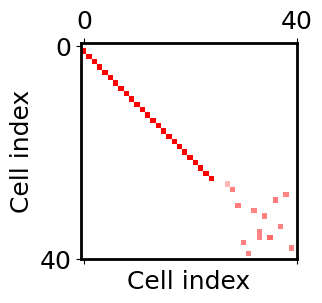

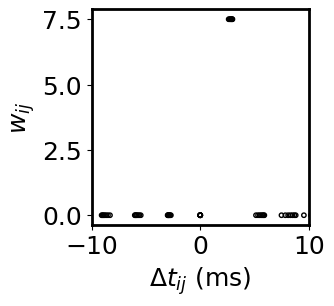

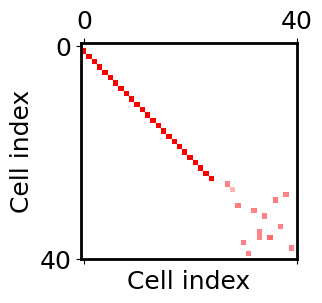

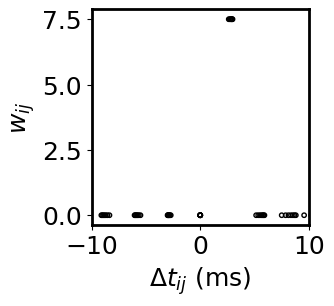

In [112]:
plot_kernel([
    './sims_out/kernel_test_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_10:45:38.154168'
], x_range=(-10, 10), n_indices=np.arange(10, 20))

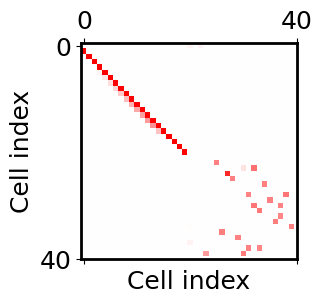

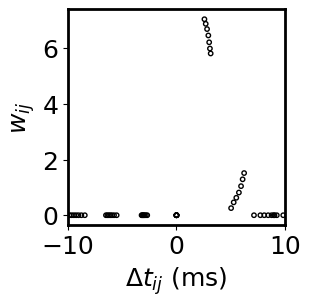

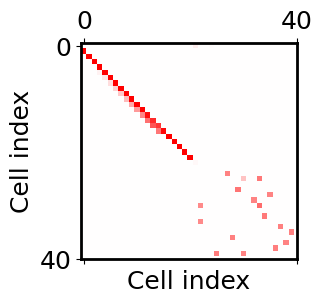

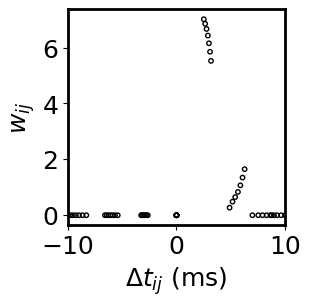

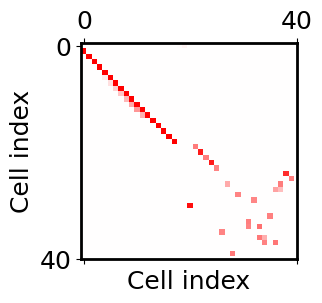

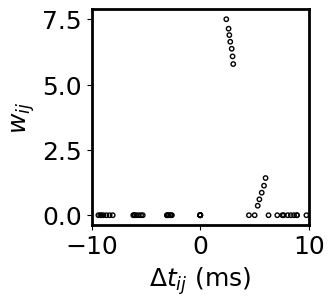

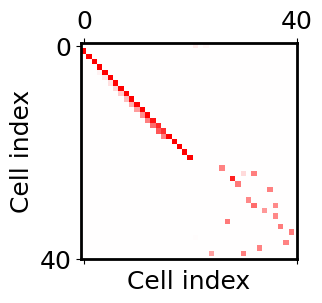

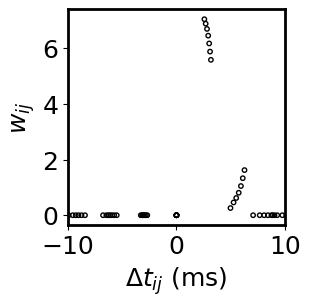

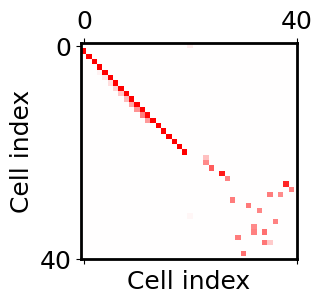

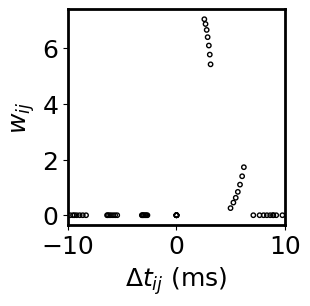

In [113]:
plot_kernel([
    './sims_out/kernel_test_ila_add_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_12:29:08.362910'
], x_range=(-10, 10), n_indices=np.arange(10, 20))

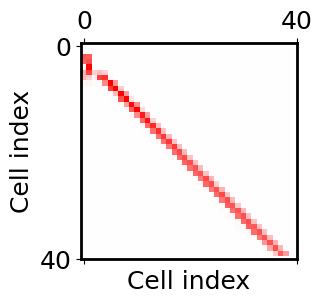

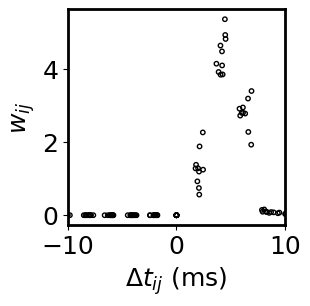

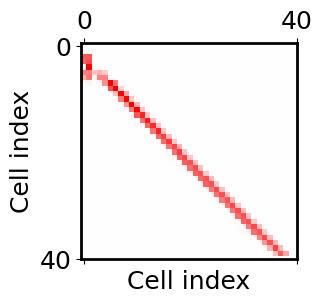

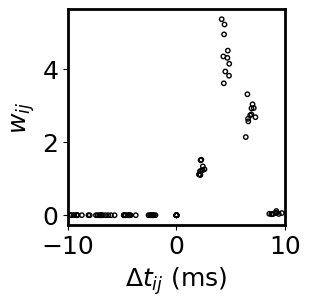

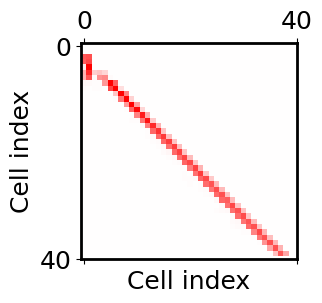

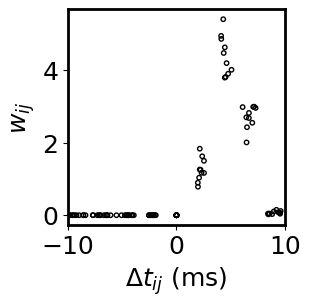

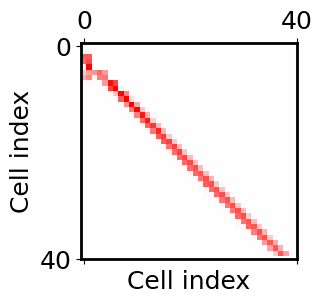

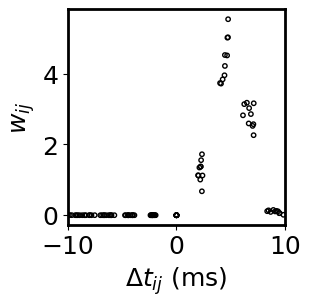

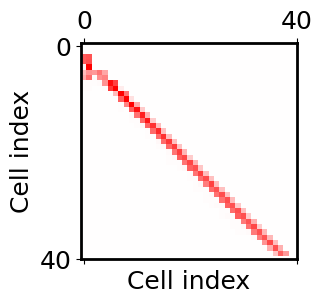

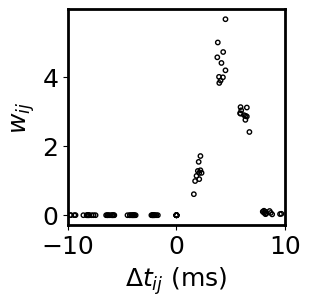

In [114]:
plot_kernel([
    './sims_out/kernel_test_mult_stdp_fr_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_12:49:35.112207'
], x_range=(-10, 10), n_indices=np.arange(10, 20))

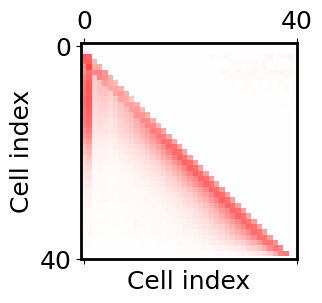

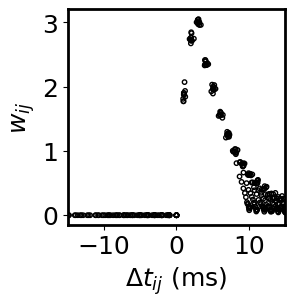

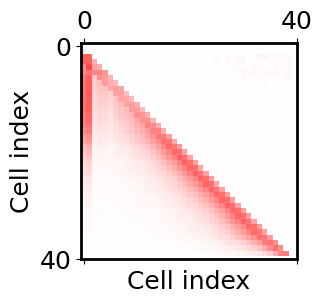

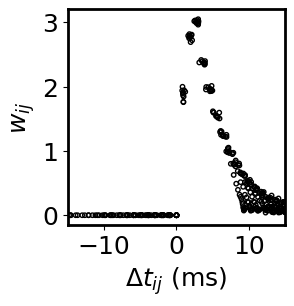

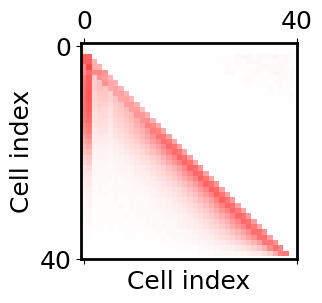

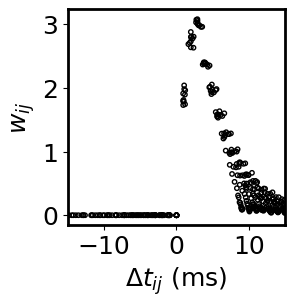

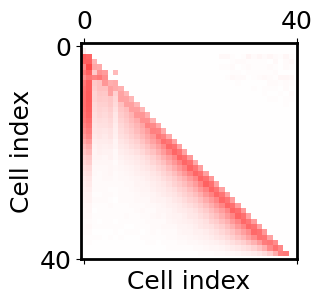

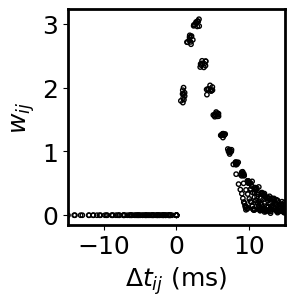

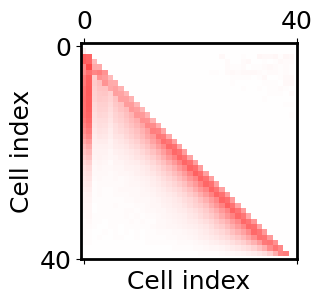

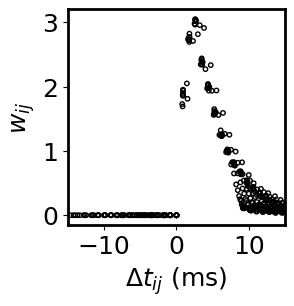

In [127]:
plot_kernel([
    './sims_out/kernel_test_discovered_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_12:19:21.056980'
], x_range=(-15, 15), n_indices=np.arange(25, 35))

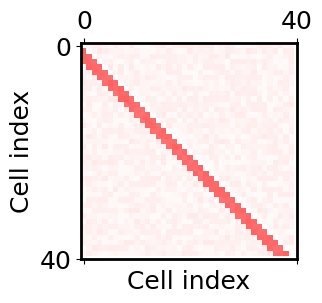

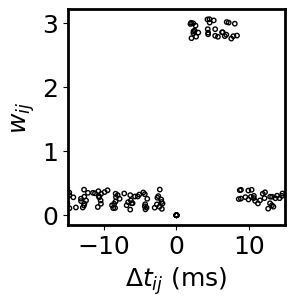

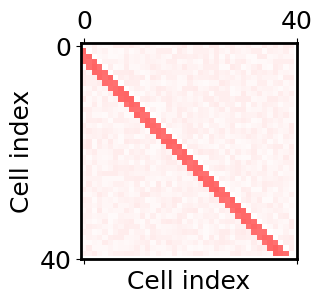

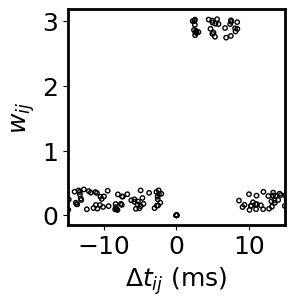

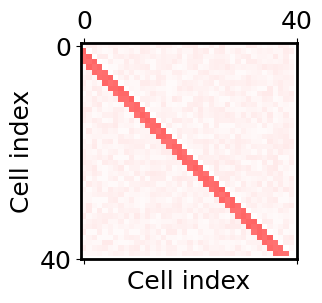

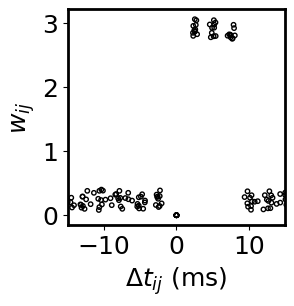

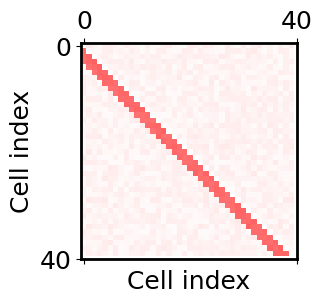

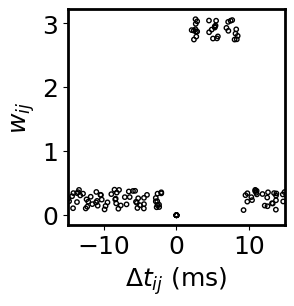

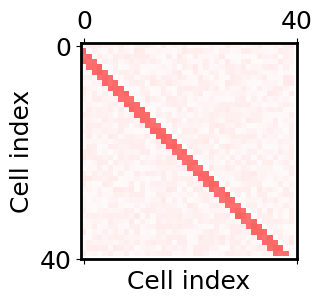

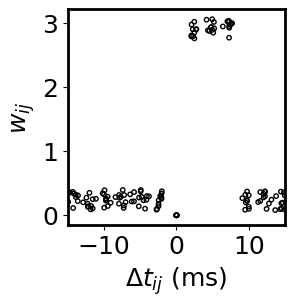

In [117]:
plot_kernel([
    './sims_out/kernel_test_none_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_14:01:23.785106'
], x_range=(-15, 15), n_indices=np.arange(10, 20))

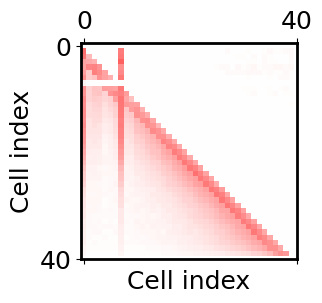

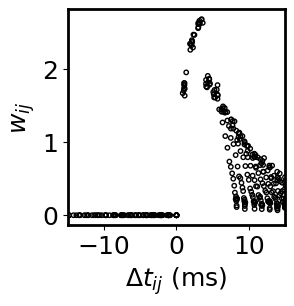

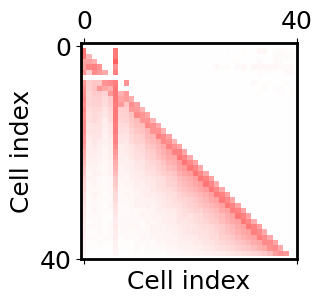

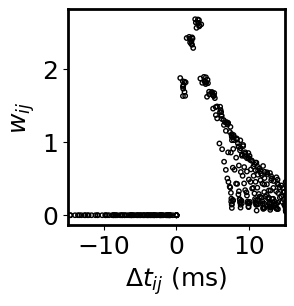

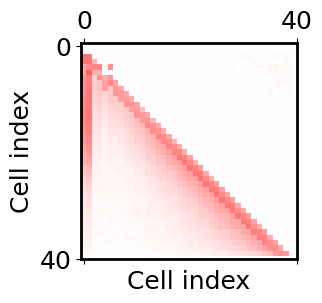

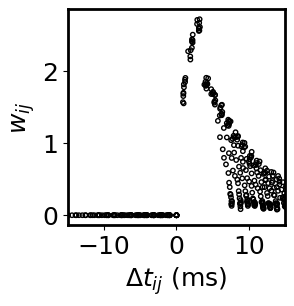

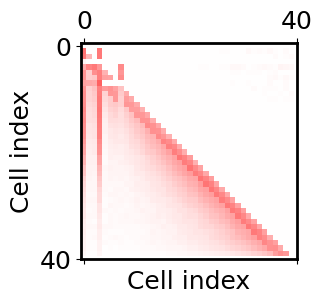

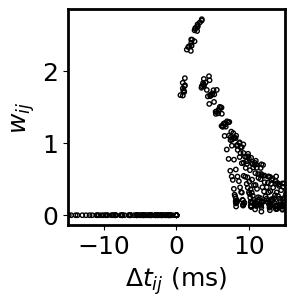

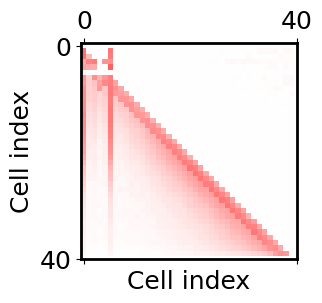

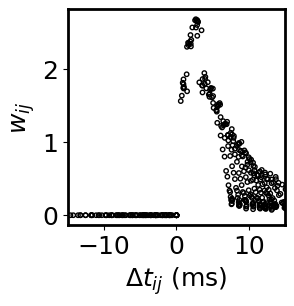

In [128]:
plot_kernel([
    './sims_out/kernel_test_discovered_8ms_stdp_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_14:27:44.216610'
], x_range=(-15, 15), n_indices=np.arange(25, 35))

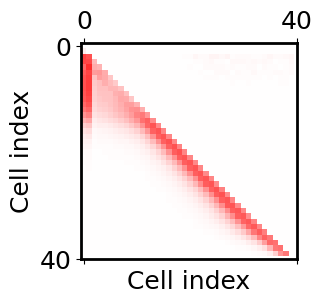

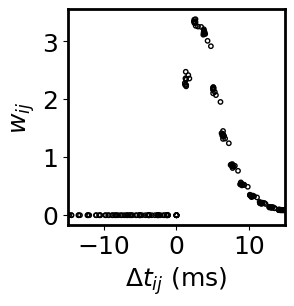

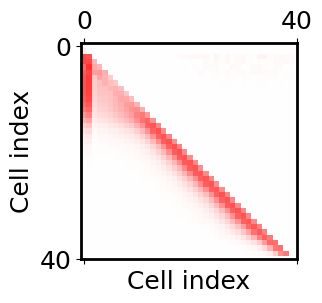

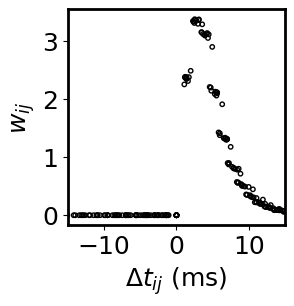

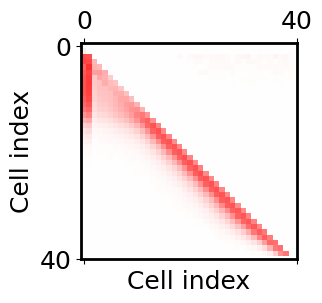

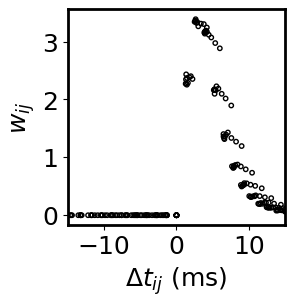

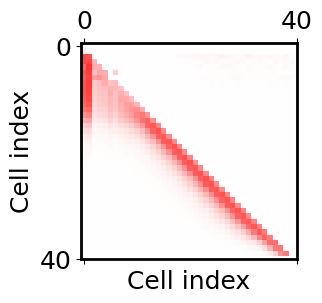

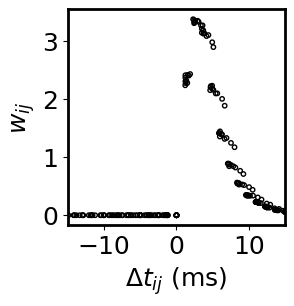

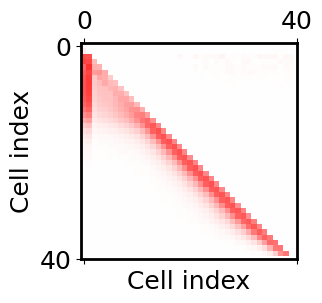

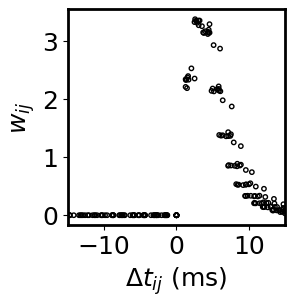

In [129]:
plot_kernel([
    './sims_out/kernel_test_discovered_3ms_stdp_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_2_2024-03-12_14:44:54.530757'
], x_range=(-15, 15), n_indices=np.arange(25, 35))

In [5]:
def sort_key(x):
    last_underscore_idx = x.rfind('_')
    x_copy = x[last_underscore_idx + 1:]
    return int(x_copy[:-4])

In [9]:
def plot_kernel_self_org(file_names, x_range=None, n_indices=None, n_exc_cells=20, n_cells=28, bin_size=10):
    scale = 0.7

    for f_idx, file_path in enumerate(file_names):
        file_name = os.path.basename(file_path)
        print(file_name)
        figure_path = f'./figures/{file_name}'
        Path(figure_path).mkdir(parents=True, exist_ok=True) 
        
        weight_mat_files = sorted(glob.glob(os.path.join(file_path, 'weight_mat_*.csv')), key=sort_key)
        saved_weights_path = weight_mat_files[-2]
        
        
        activities_mat_files = sorted(glob.glob(os.path.join(file_path, 'all_r_*.csv')), key=sort_key)
        saved_activities_path = activities_mat_files[-2]
        
        all_t_means = []
        all_t_orderings = []
        
        try:
            all_r = read_csv(saved_activities_path, read_header=False, delimiter=',', start=0)
            all_r = np.array(all_r).reshape(10, 12, 1600, 20)
            
            for network_index in range(all_r.shape[0]):
                for trial_idx in range(6, 12):
                    r = all_r[network_index, trial_idx, ...]
                    r_summed = np.sum(r, axis=0)
                    r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
                    r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
                    r_normed = r / r_summed_safe_divide
                    t = np.arange(r.shape[0]) * 1e-4 * 1e3
                    t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=0)
                    t_means[t_means == 0] = np.nan
                    t_ordering = np.argsort(t_means)
                all_t_means.append(t_means)
                all_t_orderings.append(t_ordering)

#                 scale = 1
#                 fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
#                 axs.matshow(w[:40, :40], cmap='bwr', vmax=5, vmin=-5)
        except FileNotFoundError as e:
            pass
            
        try:
            ws = read_csv(saved_weights_path, read_header=False, delimiter=',', start=0)
            ws = np.array(ws)
            
            for k in range(0, ws.shape[0], n_cells):
                network_index = int(k / n_cells)
                t_ordering = all_t_orderings[network_index]
                t_means = all_t_means[network_index]
                
                w = ws[k:k + n_cells, :]

                sorted_w = w[:n_exc_cells, :n_exc_cells][t_ordering, :][:, t_ordering]

                kernel = extract_kernel(w[:n_exc_cells, :n_exc_cells])

                fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))
                cbar = axs.matshow(sorted_w, vmax=6, vmin=-6, cmap='seismic')
                axs.set_xlabel('Cell index')
                axs.set_ylabel('Cell index')
                axs.set_xticks([0, n_exc_cells])
                axs.set_xticklabels([0, n_exc_cells])
                axs.set_yticks([0, n_exc_cells])
                axs.set_yticklabels([0, n_exc_cells])
                
                plt.colorbar(cbar, ax=axs, fraction=0.046, pad=0.04)
                
                fig.savefig(os.path.join(figure_path, f'weight_mat_{network_index}.svg'))
                fig.savefig(os.path.join(figure_path, f'weight_mat_{network_index}.png'))
                

                time_diffs = []
                weights_for_time_diffs = []
                for t_idx_i, t_mean_i in enumerate(t_means):
                    for t_idx_j, t_mean_j in enumerate(t_means):
                        if not np.isnan(t_mean_i) and not np.isnan(t_mean_j) and (n_indices is None or (t_idx_j in n_indices)):
                            time_diffs.append(t_mean_i - t_mean_j)
                            weights_for_time_diffs.append(w[t_idx_j, t_idx_i])
                            
                n_bins = int((x_range[1] - x_range[0]) / bin_size)
                time_diff_bins = np.linspace(x_range[0], x_range[1], n_bins)
                counts_for_bins = np.zeros(n_bins)
                weights_for_bins = np.zeros(n_bins)
                
                for i_c in range(len(time_diffs)):
                    td = time_diffs[i_c]
                    if td >= x_range[0] and td < x_range[1]:
                        bin_idx = int((td - x_range[0])/bin_size)
                        counts_for_bins[bin_idx] += 1
                        weights_for_bins[bin_idx] += weights_for_time_diffs[i_c]
                
                weights_for_bins[counts_for_bins > 0] /= counts_for_bins[counts_for_bins > 0]

                fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
                axs.scatter(time_diffs, weights_for_time_diffs, s=50, marker='o', alpha=0.5, facecolor='none', edgecolor='black')
                axs.plot(time_diff_bins, weights_for_bins, color='red', lw=4)
                axs.set_xlabel(r'$\Delta t_{ij}$ (ms)')
                axs.set_ylabel(r'$w_{ij}$')
                

                if x_range is not None:
                    axs.set_xlim(*x_range)
                    
                fig.savefig(os.path.join(figure_path, f'kernel_{network_index}.svg'))
                fig.savefig(os.path.join(figure_path, f'kernel_{network_index}.png'))

        except FileNotFoundError as e:
            pass

kernel_test_final_160_0_mult_ssbound_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_603_2024-05-10_15:37:53.641905


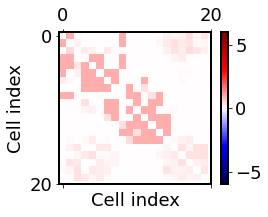

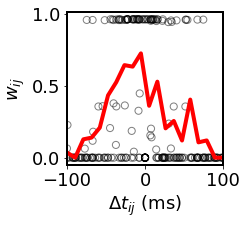

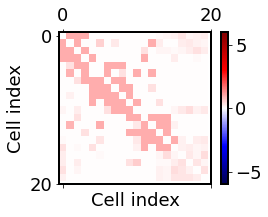

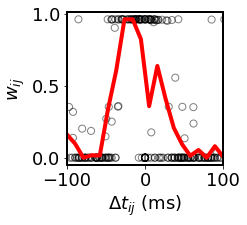

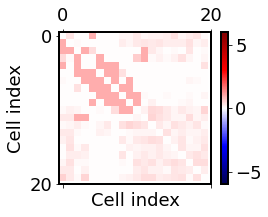

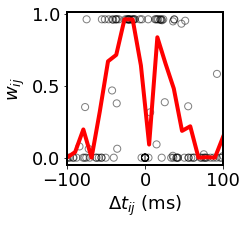

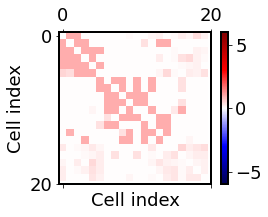

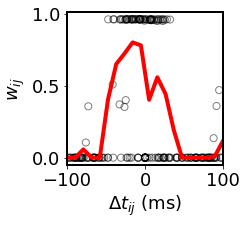

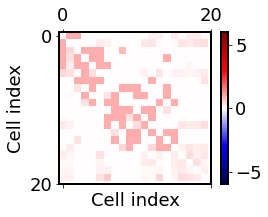

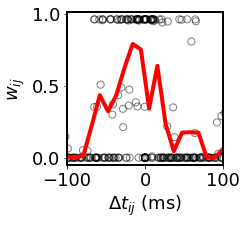

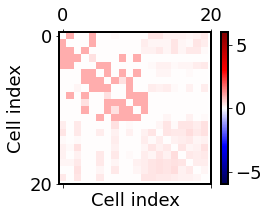

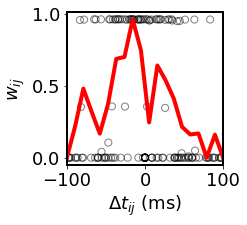

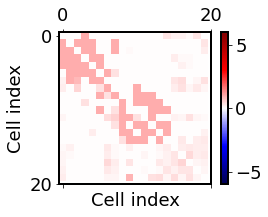

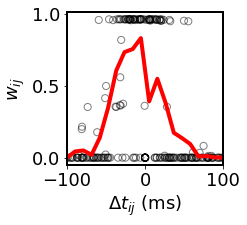

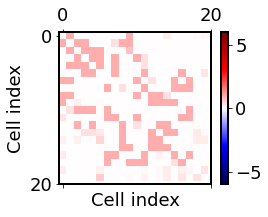

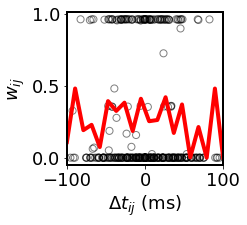

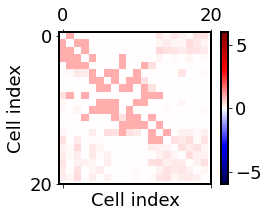

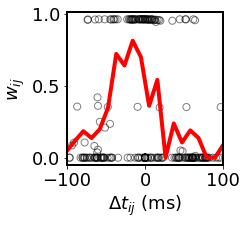

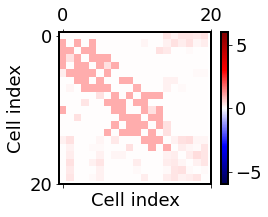

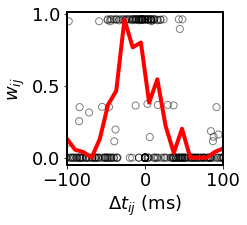

In [10]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_0_mult_ssbound_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_603_2024-05-10_15:37:53.641905',
], x_range=(-100, 100), n_indices=np.arange(0, 20))

kernel_test_final_160_1_add_ssbound_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_13:21:41.263556


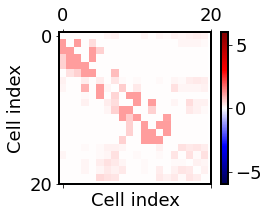

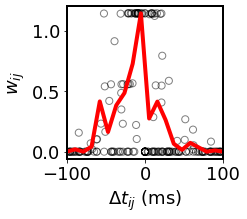

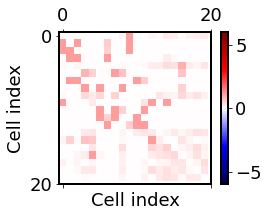

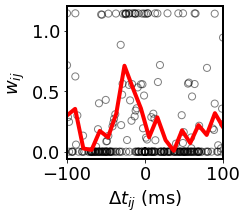

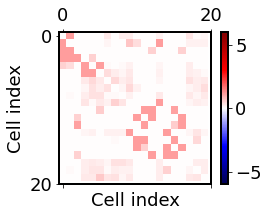

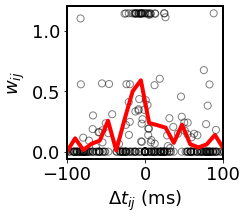

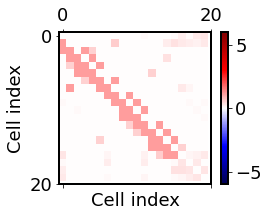

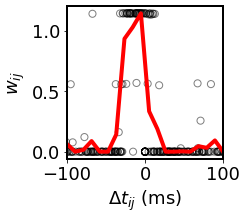

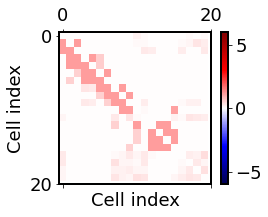

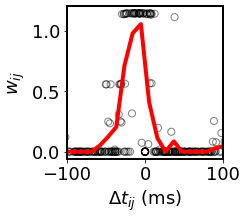

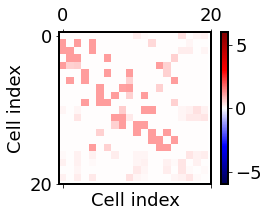

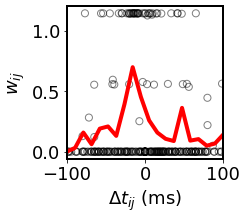

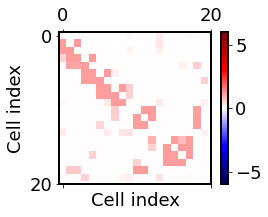

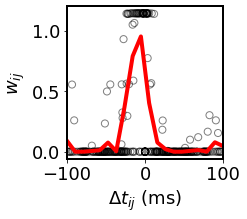

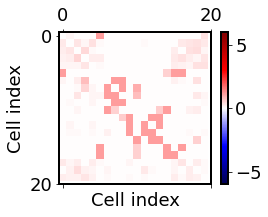

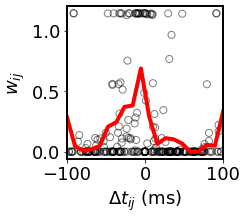

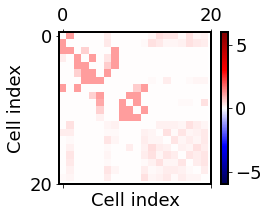

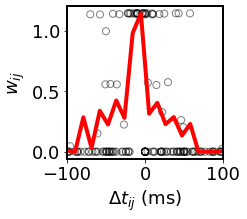

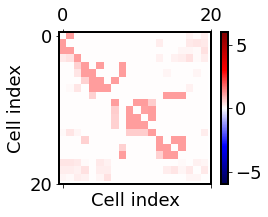

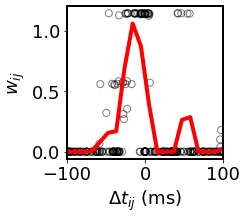

In [11]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_1_add_ssbound_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_13:21:41.263556'
], x_range=(-100, 100), n_indices=np.arange(0, 20))

kernel_test_final_160_2_mult_het_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_603_2024-05-10_16:38:07.050092


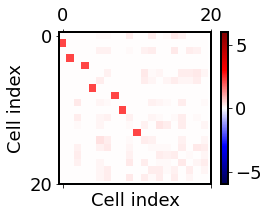

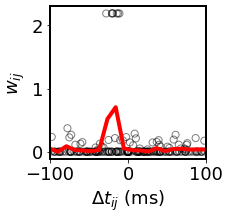

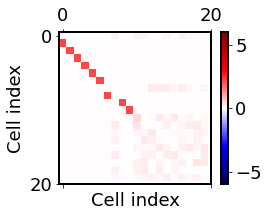

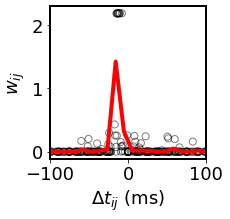

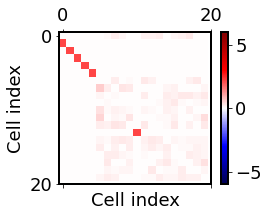

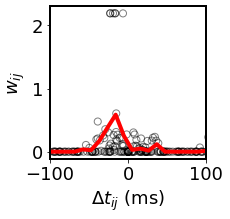

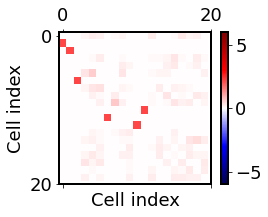

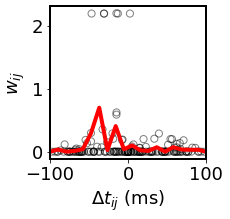

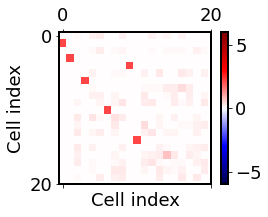

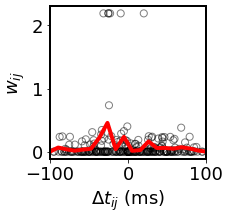

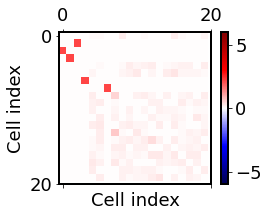

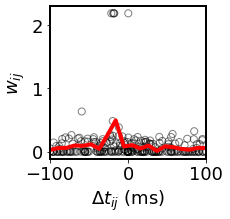

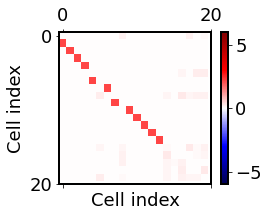

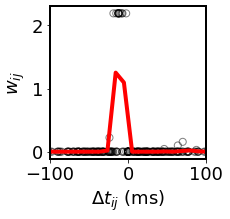

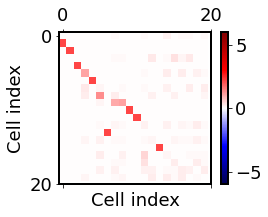

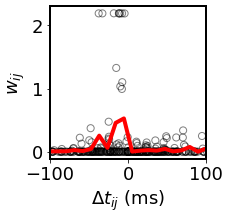

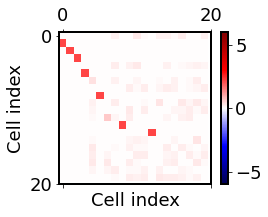

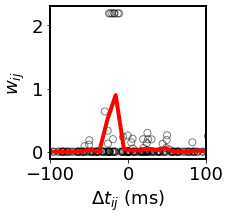

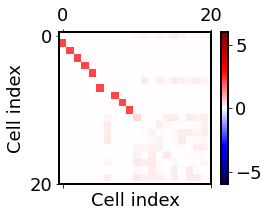

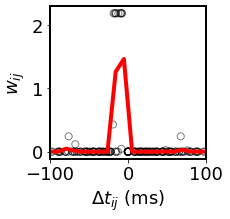

In [12]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_2_mult_het_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_603_2024-05-10_16:38:07.050092'
], x_range=(-100, 100), n_indices=np.arange(0, 20))


kernel_test_final_160_3_add_het_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_602_2024-05-10_15:37:25.874924


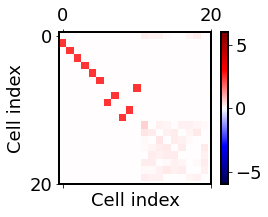

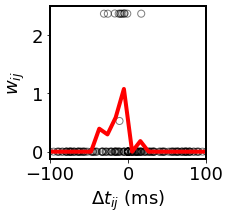

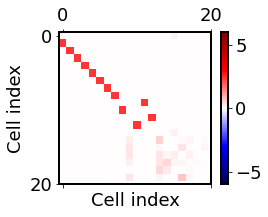

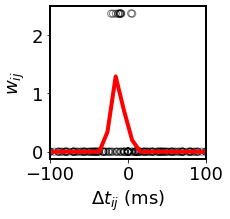

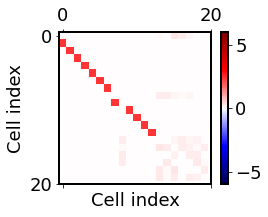

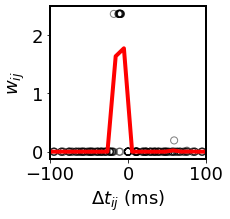

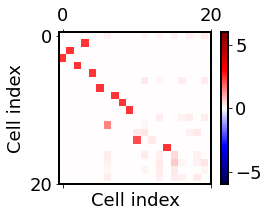

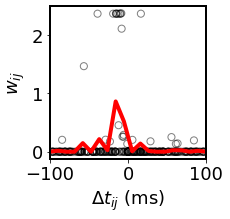

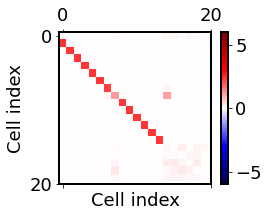

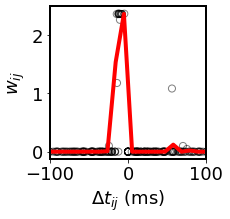

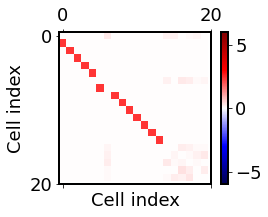

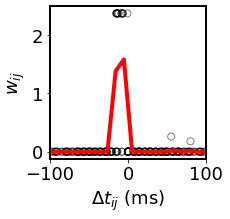

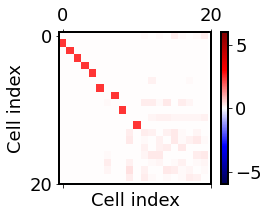

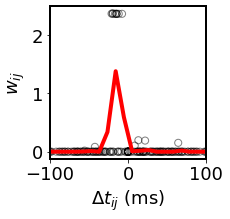

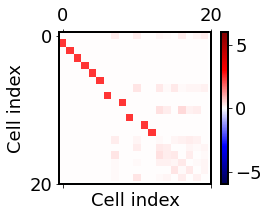

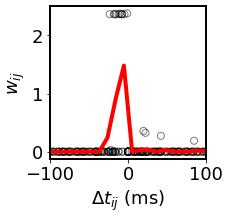

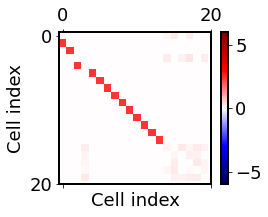

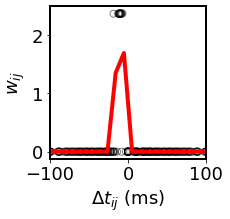

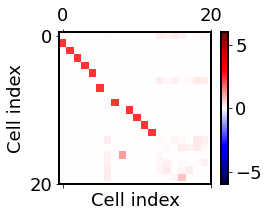

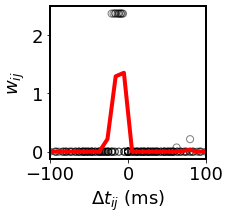

In [13]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_3_add_het_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_602_2024-05-10_15:37:25.874924'
], x_range=(-100, 100), n_indices=np.arange(0, 20))

kernel_test_final_160_4_add_wfr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_16:47:59.517826


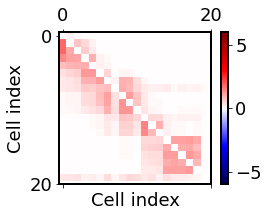

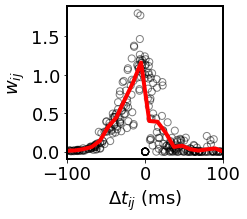

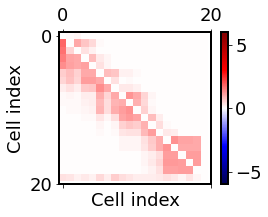

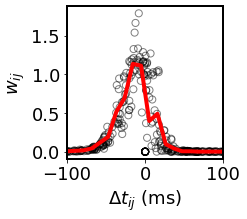

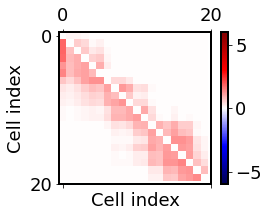

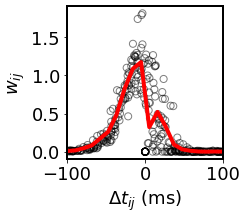

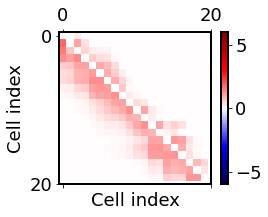

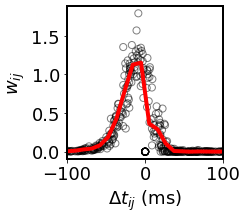

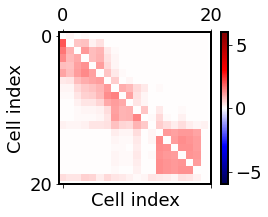

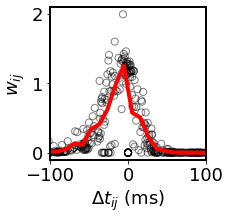

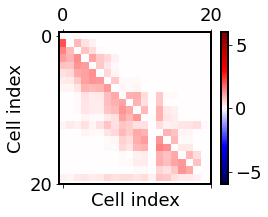

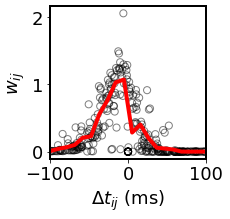

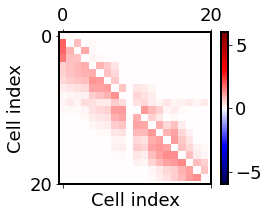

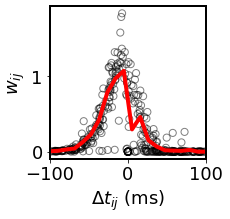

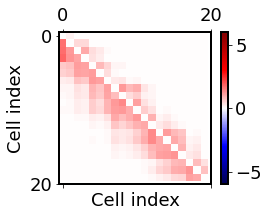

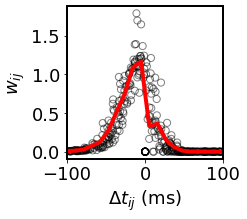

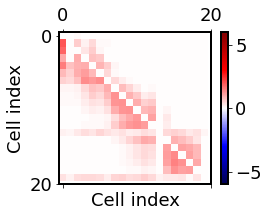

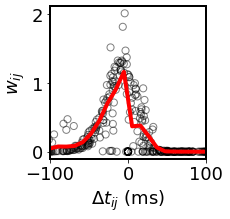

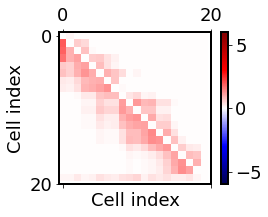

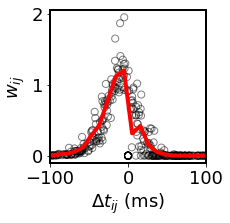

In [14]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_4_add_wfr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_16:47:59.517826'
], x_range=(-100, 100), n_indices=np.arange(0, 20))


kernel_test_final_160_5_add_fr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_16:47:52.927795


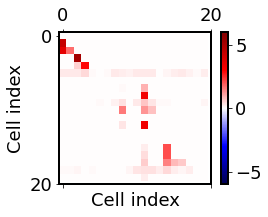

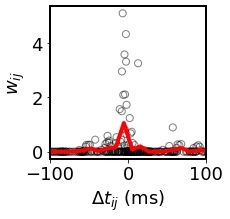

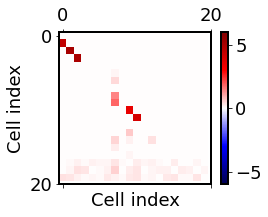

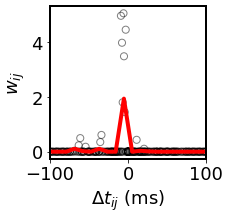

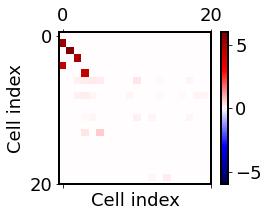

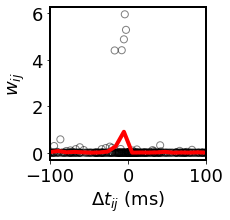

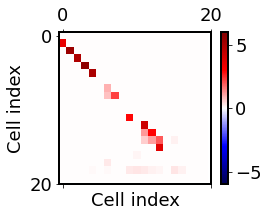

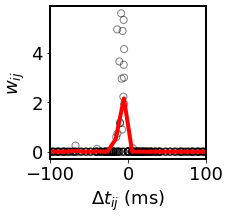

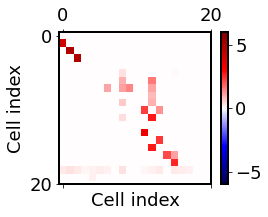

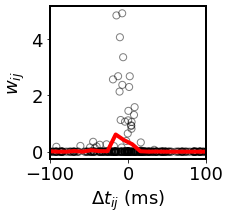

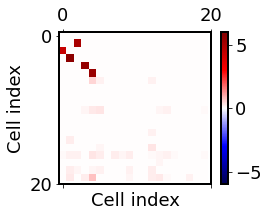

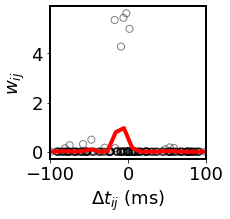

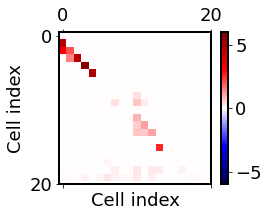

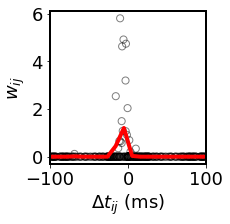

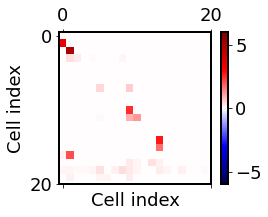

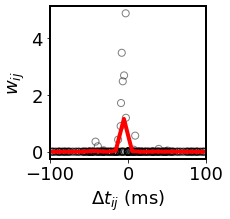

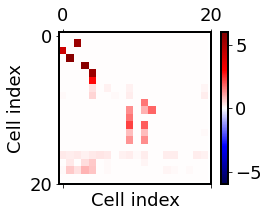

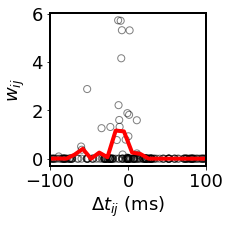

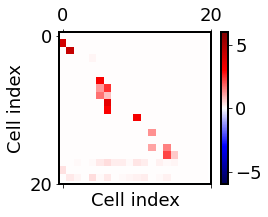

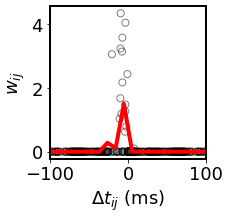

In [15]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_5_add_fr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_16:47:52.927795'
], x_range=(-100, 100), n_indices=np.arange(0, 20))

kernel_test_final_160_6_mult_wfr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_17:09:46.440201


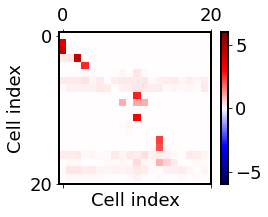

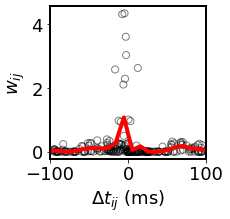

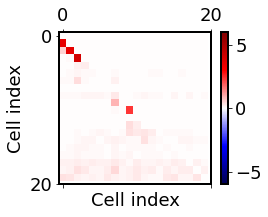

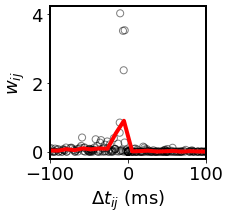

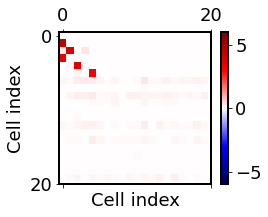

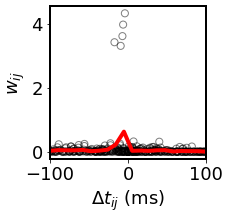

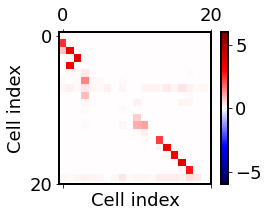

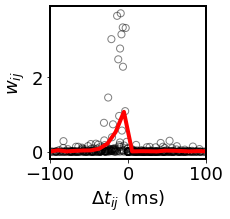

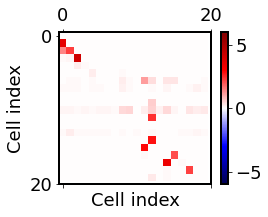

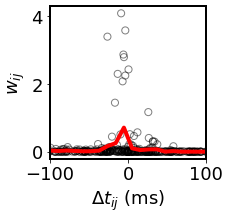

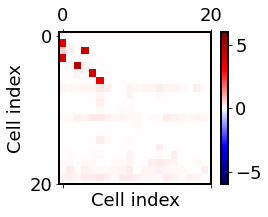

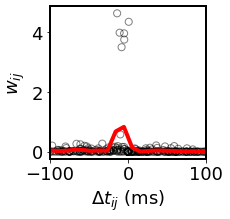

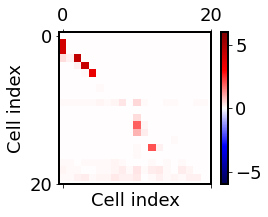

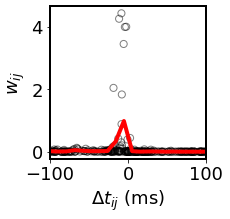

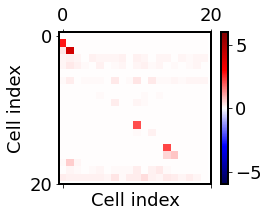

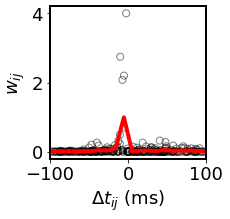

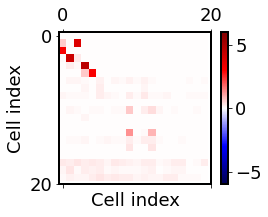

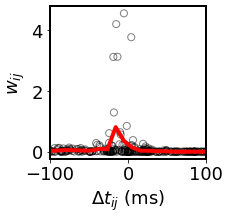

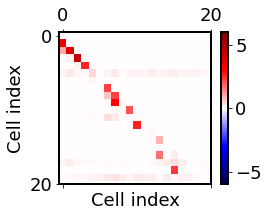

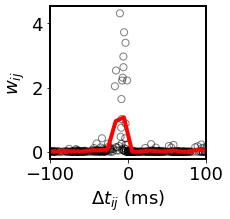

In [16]:
plot_kernel_self_org([
    './sims_out/kernel_test_final_160_6_mult_wfr_BATCH_10_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_600_2024-05-09_17:09:46.440201'
], x_range=(-100, 100), n_indices=np.arange(0, 20))

In [ ]:
def plot_losses(file_names, x_range=None, n_indices=None, n_exc_cells=20, n_cells=28, bin_size=10):
    scale = 0.7

    for f_idx, file_path in enumerate(file_names):
        file_name = os.path.basename(file_path)
        print(file_name)
        figure_path = f'./figures/{file_name}'
        Path(figure_path).mkdir(parents=True, exist_ok=True) 
        
        weight_mat_files = sorted(glob.glob(os.path.join(file_path, 'weight_mat_*.csv')), key=sort_key)
        saved_weights_path = weight_mat_files[-2]
        
        
        activities_mat_files = sorted(glob.glob(os.path.join(file_path, 'all_r_*.csv')), key=sort_key)
        saved_activities_path = activities_mat_files[-2]
        
        all_t_means = []
        all_t_orderings = []
        
        try:
            all_r = read_csv(saved_activities_path, read_header=False, delimiter=',', start=0)
            all_r = np.array(all_r).reshape(10, 12, 1600, 20)
            
            for network_index in range(all_r.shape[0]):
                for trial_idx in range(6, 12):
                    r = all_r[network_index, trial_idx, ...]
                    r_summed = np.sum(r, axis=0)
                    r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
                    r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
                    r_normed = r / r_summed_safe_divide
                    t = np.arange(r.shape[0]) * 1e-4 * 1e3
                    t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=0)
                    t_means[t_means == 0] = np.nan
                    t_ordering = np.argsort(t_means)
                all_t_means.append(t_means)
                all_t_orderings.append(t_ordering)

#                 scale = 1
#                 fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
#                 axs.matshow(w[:40, :40], cmap='bwr', vmax=5, vmin=-5)
        except FileNotFoundError as e:
            pass
            
        try:
            ws = read_csv(saved_weights_path, read_header=False, delimiter=',', start=0)
            ws = np.array(ws)
            
            for k in range(0, ws.shape[0], n_cells):
                network_index = int(k / n_cells)
                t_ordering = all_t_orderings[network_index]
                t_means = all_t_means[network_index]
                
                w = ws[k:k + n_cells, :]

                sorted_w = w[:n_exc_cells, :n_exc_cells][t_ordering, :][:, t_ordering]

                kernel = extract_kernel(w[:n_exc_cells, :n_exc_cells])

                fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))
                cbar = axs.matshow(sorted_w, vmax=6, vmin=-6, cmap='seismic')
                axs.set_xlabel('Cell index')
                axs.set_ylabel('Cell index')
                axs.set_xticks([0, n_exc_cells])
                axs.set_xticklabels([0, n_exc_cells])
                axs.set_yticks([0, n_exc_cells])
                axs.set_yticklabels([0, n_exc_cells])
                
                plt.colorbar(cbar, ax=axs, fraction=0.046, pad=0.04)
                
                fig.savefig(os.path.join(figure_path, f'weight_mat_{network_index}.svg'))
                fig.savefig(os.path.join(figure_path, f'weight_mat_{network_index}.png'))
                

                time_diffs = []
                weights_for_time_diffs = []
                for t_idx_i, t_mean_i in enumerate(t_means):
                    for t_idx_j, t_mean_j in enumerate(t_means):
                        if not np.isnan(t_mean_i) and not np.isnan(t_mean_j) and (n_indices is None or (t_idx_j in n_indices)):
                            time_diffs.append(t_mean_i - t_mean_j)
                            weights_for_time_diffs.append(w[t_idx_j, t_idx_i])
                            
                n_bins = int((x_range[1] - x_range[0]) / bin_size)
                time_diff_bins = np.linspace(x_range[0], x_range[1], n_bins)
                counts_for_bins = np.zeros(n_bins)
                weights_for_bins = np.zeros(n_bins)
                
                for i_c in range(len(time_diffs)):
                    td = time_diffs[i_c]
                    if td >= x_range[0] and td < x_range[1]:
                        bin_idx = int((td - x_range[0])/bin_size)
                        counts_for_bins[bin_idx] += 1
                        weights_for_bins[bin_idx] += weights_for_time_diffs[i_c]
                
                weights_for_bins[counts_for_bins > 0] /= counts_for_bins[counts_for_bins > 0]

                fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
                axs.scatter(time_diffs, weights_for_time_diffs, s=50, marker='o', alpha=0.5, facecolor='none', edgecolor='black')
                axs.plot(time_diff_bins, weights_for_bins, color='red', lw=4)
                axs.set_xlabel(r'$\Delta t_{ij}$ (ms)')
                axs.set_ylabel(r'$w_{ij}$')
                

                if x_range is not None:
                    axs.set_xlim(*x_range)
                    
                fig.savefig(os.path.join(figure_path, f'kernel_{network_index}.svg'))
                fig.savefig(os.path.join(figure_path, f'kernel_{network_index}.png'))

        except FileNotFoundError as e:
            pass